In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

zsh:1: command not found: nvidia-smi


In [194]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from enum import Enum
import imageio
import hashlib
import copy
import time
import abc
import random
import collections
import itertools
import pickle
import datetime
from sklearn import model_selection

%matplotlib inline
plt.style.use('seaborn-paper')
%config InlineBackend.figure_format='retina'

dtype = 'float32'
tf.keras.backend.set_floatx(dtype)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# set matplotlib font to Times
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [334]:
################################################################################
# DATASETS
################################################################################


def get_dataset_sample(X, y, fraction, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Set random seed
    selection = np.random.choice([True, False], len(X), p=[fraction, 1 - fraction])
    if seed is not None:
        np.random.seed()  # Unset random seed
    X_sampled = X[selection]
    y_sampled = y[selection]
    return X_sampled, y_sampled


class Dataset:
    def __init__(self, X_train, y_train, X_test, y_test, shape, shape_flattened, fraction, vision=True, standardize=True):
        if fraction is not None:
            X_train, y_train = get_dataset_sample(X_train, y_train, fraction, seed=42)
            X_test, y_test = get_dataset_sample(X_test, y_test, fraction, seed=42)
        
        X_train = X_train.astype(dtype)
        y_train = y_train.astype(dtype)
        X_test = X_test.astype(dtype)
        y_test = y_test.astype(dtype)

        if vision:
            X_train = X_train / 255.0
            X_test = X_test / 255.0

        X_train = np.reshape(X_train, shape_flattened)
        X_test = np.reshape(X_test, shape_flattened)
        
        X = np.concatenate((X_train, X_test), axis=0)
        y = np.concatenate((y_train, y_test), axis=0)

        if standardize:
            from sklearn.preprocessing import StandardScaler

            scaler = StandardScaler()
            scaler.fit(X_train)  # Scaling each feature independently

            X_norm = scaler.transform(X)
            X_train_norm = scaler.transform(X_train)
            X_test_norm = scaler.transform(X_test)
        else:
            X_norm = X.copy()
            X_train_norm = X_train.copy()
            X_test_norm = X_test.copy()

        X_norm = np.reshape(X_norm, shape)
        X_train_norm = np.reshape(X_train_norm, shape)
        X_test_norm = np.reshape(X_test_norm, shape)

        del X, X_train, X_test
        
        # Shuffle X_norm and y
        assert len(X_norm) == len(y)
        p = np.random.permutation(len(X_norm))
        X_norm, y = X_norm[p], y[p]

        self.X_norm = X_norm
        self.y = y
        self.X_train_norm = X_train_norm
        self.y_train = y_train
        self.X_test_norm = X_test_norm
        self.y_test = y_test


def get_cifar_10_dataset(fraction=None):
    cifar10 = tf.keras.datasets.cifar10
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    shape = (-1, 32, 32, 3)
    shape_flattened = (-1, 3072)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, fraction=fraction)


def get_cifar_100_dataset(fraction=None):
    cifar100 = tf.keras.datasets.cifar100
    (X_train, y_train), (X_test, y_test) = cifar100.load_data()
    shape = (-1, 32, 32, 3)
    shape_flattened = (-1, 3072)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, fraction=fraction)


def get_svhn_dataset(fraction=None):
    from urllib.request import urlretrieve
    from scipy import io

    train_filename, _ = urlretrieve('http://ufldl.stanford.edu/housenumbers/train_32x32.mat')
    test_filename, _ = urlretrieve('http://ufldl.stanford.edu/housenumbers/test_32x32.mat')

    X_train = io.loadmat(train_filename, variable_names='X').get('X')
    y_train = io.loadmat(train_filename, variable_names='y').get('y')
    X_test = io.loadmat(test_filename, variable_names='X').get('X')
    y_test = io.loadmat(test_filename, variable_names='y').get('y')

    X_train = np.moveaxis(X_train, -1, 0)
    y_train -= 1
    X_test = np.moveaxis(X_test, -1, 0)
    y_test -= 1

    shape = (-1, 32, 32, 3)
    shape_flattened = (-1, 3072)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, fraction=fraction)


def get_tiny_imagenet_dataset(fraction=None):
    """
    Original source: https://github.com/sonugiri1043/Train_ResNet_On_Tiny_ImageNet/blob/master/Train_ResNet_On_Tiny_ImageNet.ipynb
    Original author: sonugiri1043@gmail.com
    """

    if not os.path.isdir('IMagenet'):
        ! git clone https://github.com/seshuad/IMagenet

    print("Processing the downloaded dataset...")

    path = 'IMagenet/tiny-imagenet-200/'

    id_dict = {}
    for i, line in enumerate(open(path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i

    train_data = list()
    test_data = list()
    train_labels = list()
    test_labels = list()

    for key, value in id_dict.items():
        train_data += [imageio.imread(path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), pilmode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open(path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(imageio.imread(path + 'val/images/{}'.format(img_name), pilmode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    X_train = np.array(train_data)
    y_train = np.argmax(np.array(train_labels), axis=1)
    X_test = np.array(test_data)
    y_test = np.argmax(np.array(test_labels), axis=1)

    shape = (-1, 64, 64, 3)
    shape_flattened = (-1, 12288)  # Scaling each feature independently
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, fraction=fraction)


def get_mnist_dataset(fraction=None):
    mnist = tf.keras.datasets.mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    shape = (-1, 28, 28, 1)
    shape_flattened = (-1, 1)  # Scaling all features together
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, fraction=fraction)


def get_fashion_mnist_dataset(fraction=None):
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    shape = (-1, 28, 28, 1)
    shape_flattened = (-1, 1)  # Scaling all features together
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, fraction=fraction)


def get_fifteen_puzzle_dataset(path=None, fraction=None):
    from sklearn.model_selection import train_test_split

    if path is None:
        from google.colab import drive
        drive.mount('/content/gdrive')
        path = 'gdrive/MyDrive/15-costs-v3.csv'
    costs = pd.read_csv(path)

    X_raw = costs.iloc[:,:-1].values
    y = costs['cost'].values
    X = np.apply_along_axis(lambda x: np.eye(16)[x].ravel(), 1, X_raw)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, X_raw, y

    shape = (-1, 256)
    shape_flattened = (-1, 256)  # Scaling all features together
    return Dataset(X_train, y_train, X_test, y_test, shape=shape, shape_flattened=shape_flattened, vision=False, fraction=fraction)


################################################################################
# REGULARIZERS
################################################################################


class Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self):
        self.n_new_neurons = 0
        self.scaling_tensor = None
        self.set_regularization_penalty(0.)
        self.set_regularization_method(None)
    
    def copy(self):
        regularizer_copy = Regularizer.__new__(Regularizer)
        regularizer_copy.n_new_neurons = self.n_new_neurons
        regularizer_copy.scaling_tensor = self.scaling_tensor
        regularizer_copy.set_regularization_penalty(self.regularization_penalty)
        regularizer_copy.set_regularization_method(self.regularization_method)
        return regularizer_copy

    def __call__(self, x):
        if self.regularization_method is None or self.regularization_penalty == 0:
            return 0
        elif self.regularization_method == 'weighted_l1':
            return self.weighted_l1(x)
        elif self.regularization_method == 'weighted_l1_reordered':
            return self.weighted_l1_reordered(x)
        elif self.regularization_method == 'group_sparsity':
            return self.group_sparsity(x)
        elif self.regularization_method == 'l1':
            return self.l1(x)
        else:
            raise NotImplementedError(f"Unknown regularization method {self.regularization_method}")
    
    def weighted_l1(self, x):
        # I.e. for a parameter matrix of 4 input and 10 output neurons:
        #
        # [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]
        #
        # the scaling tensor, as well as the resulting weighted values, could be:
        #
        # [[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]
        #
        # Therefore every additional output neuron is regularized more.

        scaling_tensor = tf.cumsum(tf.constant(self.regularization_penalty, shape=x.shape, dtype=dtype), axis=-1)
        weighted_values = scaling_tensor * tf.abs(x)
        return tf.reduce_sum(weighted_values)
    
    def weighted_l1_reordered(self, x):
        # I.e. for a parameter matrix of 4 input and 10 output neurons:
        #
        # [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        #  [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]
        #
        # the scaling tensor, as well as the resulting weighted values, could be:
        #
        # [[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        #  [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]
        #
        # Therefore every additional output neuron is regularized more.

        if self.update_scaling_tensor:
            scaling_tensor_raw = tf.cumsum(tf.constant(self.regularization_penalty, shape=x.shape, dtype=dtype), axis=-1)

            scaling_tensor_old_neurons = scaling_tensor_raw[:, :-self.n_new_neurons]
            scaling_tensor_new_neurons = scaling_tensor_raw[:, -self.n_new_neurons:]
            scaling_tensor_old_neurons_shuffled = tf.transpose(tf.random.shuffle(tf.transpose(scaling_tensor_old_neurons)))
            self.scaling_tensor = tf.concat([scaling_tensor_old_neurons_shuffled, scaling_tensor_new_neurons], axis=-1)
            self.update_scaling_tensor = False

        weighted_values = self.scaling_tensor * tf.abs(x)
        return tf.reduce_sum(weighted_values)
    
    def group_sparsity(self, x):
        # I.e. for a parameter matrix of 3 input and 5 output neurons:
        #
        # [[1., 1., 1., 1., 1.],
        #  [1., 2., 2., 1., 2.],
        #  [2., 2., 3., 1., 3.]]
        #
        # The resulting vector of group norms is [2., 2., 3., 1., 3.], therefore for
        # every output neuron, its incoming connections form a group.

        group_norms = tf.norm(x, ord=2, axis=0)
        # assert group_norms.shape[0] == x.shape[1]
        return self.regularization_penalty * tf.reduce_sum(group_norms)
    
    def l1(self, x):
        weighted_values = self.regularization_penalty * tf.abs(x)
        return tf.reduce_sum(weighted_values)
    
    def prune(self):
        self.n_new_neurons = 0
        if self.regularization_method == 'weighted_l1_reordered':
            self.update_scaling_tensor = True
    
    def grow(self, n_new_neurons):
        self.n_new_neurons = n_new_neurons
        if self.regularization_method == 'weighted_l1_reordered':
            self.update_scaling_tensor = True
    
    def set_regularization_penalty(self, regularization_penalty):
        self.regularization_penalty = regularization_penalty
    
    def set_regularization_method(self, regularization_method):
        self.regularization_method = regularization_method
        if self.regularization_method == 'weighted_l1_reordered':
            self.update_scaling_tensor = True
        else:
            self.update_scaling_tensor = None

    def get_config(self):
        return {'regularization_penalty': float(self.regularization_penalty)}


################################################################################
# LAYERS
################################################################################


class DASLayer(tf.keras.layers.Layer):
    def __init__(self, input_shape):
        super().__init__()

        self._input_shape = input_shape
        self._built = False


class Dense(DASLayer):
    def __init__(self, units, activation, kernel_initializer='glorot_uniform', 
                 bias_initializer='zeros', input_shape=None, fixed_size=False,
                 regularizer=None):
        super().__init__(input_shape)

        self.units = units
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.fixed_size = fixed_size
        
        self.A = tf.keras.activations.get(activation)
        self.W_init = tf.keras.initializers.get(kernel_initializer)
        self.b_init = tf.keras.initializers.get(bias_initializer)
        if regularizer is not None:
            self.regularizer = regularizer
        else:
            self.regularizer = Regularizer()
    
    def copy(self):
        layer_copy = Dense.__new__(Dense)
        super(Dense, layer_copy).__init__(self._input_shape)
        
        layer_copy.units = self.units
        layer_copy.activation = self.activation
        layer_copy.kernel_initializer = self.kernel_initializer
        layer_copy.bias_initializer = self.bias_initializer
        layer_copy.fixed_size = self.fixed_size
        
        layer_copy.A = self.A
        layer_copy.W_init = self.W_init
        layer_copy.b_init = self.b_init
        layer_copy.regularizer = self.regularizer.copy()
        
        layer_copy.W = tf.Variable(
            name='W',
            initial_value=self.W,
            trainable=True)
        
        layer_copy.b = tf.Variable(
            name='b',
            initial_value=self.b,
            trainable=True)
        
        layer_copy.add_regularizer_loss()
        
        layer_copy._built = True
        return layer_copy
    
    def build(self, input_shape):
        if self._built:
            return
            
        input_units = input_shape[-1]

        self.W = tf.Variable(
            name='W',
            initial_value=self.W_init(shape=(input_units, self.units), dtype=dtype),
            trainable=True)
        
        self.b = tf.Variable(
            name='b',
            initial_value=self.b_init(shape=(self.units,), dtype=dtype),
            trainable=True)
        
        self.add_regularizer_loss()
        
        self._built = True
    
    def call(self, inputs, training=None):
        return self.A(tf.matmul(inputs, self.W) + self.b)
    
    def add_regularizer_loss(self):
        self.add_loss(lambda: self.regularizer(tf.concat([self.W, tf.reshape(self.b, (1, -1))], axis=0)))

    def get_size(self):
        return self.W.shape[0], self.W.shape[1]
    
    def prune(self, threshold, active_input_units_indices):
        # Remove connections from pruned units in previous layer
        new_W = tf.gather(self.W.value(), active_input_units_indices, axis=0)

        if self.fixed_size:
            active_output_neurons_indices = list(range(new_W.shape[1]))
        else:
            # Prune units in this layer
            weights_with_biases = tf.concat([new_W, tf.reshape(self.b.value(), (1, -1))], axis=0)
            neurons_are_active = tf.math.reduce_max(tf.abs(weights_with_biases), axis=0) >= threshold
            active_output_neurons_indices = tf.reshape(tf.where(neurons_are_active), (-1,))
            
            new_W = tf.gather(new_W, active_output_neurons_indices, axis=1)
            new_b = tf.gather(self.b.value(), active_output_neurons_indices, axis=0)

            self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.W = tf.Variable(name='W', initial_value=new_W, trainable=True)

        self.regularizer.prune()
        return active_output_neurons_indices
    
    def grow(self, n_new_input_units, percentage, min_new_units, scaling_factor):
        if n_new_input_units > 0:
            # Add connections to grown units in previous layer
            W_growth = self.W_init(shape=(self.W.shape[0] + n_new_input_units, self.W.shape[1]), dtype=dtype)[-n_new_input_units:, :] * scaling_factor  # TODO is it better to be multiplying here by scaling_factor? It does help with not increasing the max weights of existing neurons when new neurons are added.
            new_W = tf.concat([self.W.value(), W_growth], axis=0)
        else:
            new_W = self.W.value()

        if self.fixed_size:
            n_new_output_units = 0
        else:
            # Grow new units in this layer
            n_new_output_units = max(min_new_units, int(new_W.shape[1] * percentage))
            if n_new_output_units > 0:
                W_growth = self.W_init(shape=(new_W.shape[0], new_W.shape[1] + n_new_output_units), dtype=dtype)[:, -n_new_output_units:] * scaling_factor
                b_growth = self.b_init(shape=(n_new_output_units,), dtype=dtype)  # TODO for all possible bias initializers to work properly, the whole bias vector should be initialized at once
                new_W = tf.concat([new_W, W_growth], axis=1)
                new_b = tf.concat([self.b.value(), b_growth], axis=0)

                self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.W = tf.Variable(name='W', initial_value=new_W, trainable=True)

        self.regularizer.grow(n_new_output_units)
        return n_new_output_units
    
    def mutate(self, mutation_strength):
        self.W.assign_add(tf.random.normal(self.W.shape, mean=0.0, stddev=mutation_strength))
        self.b.assign_add(tf.random.normal(self.b.shape, mean=0.0, stddev=mutation_strength))
    
    def set_regularization_penalty(self, regularization_penalty):
        if not self.fixed_size:
            self.regularizer.set_regularization_penalty(regularization_penalty)
    
    def set_regularization_method(self, regularization_method):
        if not self.fixed_size:
            self.regularizer.set_regularization_method(regularization_method)
    
    def get_param_string():
        param_string = ""
        weights_with_bias = tf.concat([self.W, tf.reshape(self.b, (1, -1))], axis=0)
        max_parameters = tf.math.reduce_max(tf.abs(weights_with_bias), axis=0).numpy()
        magnitudes = np.floor(np.log10(max_parameters))
        for m in magnitudes:
            if m > 0:
                m = 0
            param_string += str(int(-m))
        return param_string


class Conv2D(DASLayer):
    def __init__(self, filters, filter_size, activation, strides=(1, 1), 
                 padding='SAME', kernel_initializer='glorot_uniform',
                 bias_initializer='zeros', input_shape=None, fixed_size=False,
                 regularizer=None):
        super().__init__(input_shape)
    
        self.filters = filters
        self.filter_size = filter_size
        self.activation = activation
        self.strides = strides
        self.padding = padding
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.fixed_size = fixed_size
        
        self.A = tf.keras.activations.get(activation)
        self.F_init = tf.keras.initializers.get(kernel_initializer)
        self.b_init = tf.keras.initializers.get(bias_initializer)
        if regularizer is not None:
            self.regularizer = regularizer
        else:
            self.regularizer = Regularizer()
    
    def copy(self):
        layer_copy = Conv2D.__new__(Conv2D)
        super(Conv2D, layer_copy).__init__(self._input_shape)
        
        layer_copy.filters = self.filters
        layer_copy.filter_size = self.filter_size
        layer_copy.activation = self.activation
        layer_copy.strides = self.strides
        layer_copy.padding = self.padding
        layer_copy.kernel_initializer = self.kernel_initializer
        layer_copy.bias_initializer = self.bias_initializer
        layer_copy.fixed_size = self.fixed_size
        
        layer_copy.A = self.A
        layer_copy.F_init = self.F_init
        layer_copy.b_init = self.b_init
        layer_copy.regularizer = self.regularizer.copy()
        
        layer_copy.F = tf.Variable(
            name='F',
            initial_value=self.F,
            trainable=True)
        
        layer_copy.b = tf.Variable(
            name='b',
            initial_value=self.b,
            trainable=True)
        
        layer_copy.add_regularizer_loss()
        
        layer_copy._built = True
        return layer_copy
    
    def build(self, input_shape):
        if self._built:
            return

        input_filters = input_shape[-1]

        self.F = tf.Variable(
            name='F',
            initial_value=self.F_init(
                shape=(self.filter_size[0], self.filter_size[1], input_filters, self.filters), dtype=dtype
            ),
            trainable=True)
        
        self.b = tf.Variable(
            name='b',
            initial_value=self.b_init(shape=(self.filters,), dtype=dtype),
            trainable=True)

        self.add_regularizer_loss()
        
        self._built = True
    
    def call(self, inputs, training=None):
        y = tf.nn.conv2d(inputs, self.F, strides=self.strides, padding=self.padding)
        y = tf.nn.bias_add(y, self.b)
        y = self.A(y)
        return y
    
    def add_regularizer_loss(self):
        self.add_loss(lambda: self.regularizer(tf.concat([tf.reshape(self.F, (-1, self.F.shape[-1])), tf.reshape(self.b, (1, -1))], axis=0)))
    
    def get_size(self):
        return self.F.shape[-2], self.F.shape[-1]
    
    def prune(self, threshold, active_input_units_indices):
        # Remove connections from pruned units in previous layer
        new_F = tf.gather(self.F.value(), active_input_units_indices, axis=-2)

        if self.fixed_size:
            active_output_filters_indices = list(range(new_F.shape[-1]))
        else:
            # Prune units in this layer
            F_reduced_max = tf.reshape(tf.math.reduce_max(tf.abs(new_F), axis=(0, 1, 2)), (1, -1))
            F_reduced_max_with_biases = tf.concat([F_reduced_max, tf.reshape(self.b.value(), (1, -1))], axis=0)
            filters_are_active = tf.math.reduce_max(tf.abs(F_reduced_max_with_biases), axis=0) >= threshold
            active_output_filters_indices = tf.reshape(tf.where(filters_are_active), (-1,))
            
            new_F = tf.gather(new_F, active_output_filters_indices, axis=-1)
            new_b = tf.gather(self.b.value(), active_output_filters_indices, axis=0)

            self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.F = tf.Variable(name='F', initial_value=new_F, trainable=True)

        self.regularizer.prune()
        return active_output_filters_indices

    def grow(self, n_new_input_units, percentage, min_new_units, scaling_factor):
        if n_new_input_units > 0:
            # Add connections to grown units in previous layer
            F_growth = self.F_init(shape=(self.F.shape[0], self.F.shape[1], self.F.shape[2] + n_new_input_units, self.F.shape[3]), dtype=dtype)[:, :, -n_new_input_units:, :] * scaling_factor  # TODO is it better to be multiplying here by scaling_factor? It does help with not increasing the max weights of existing neurons when new neurons are added.
            new_F = tf.concat([self.F.value(), F_growth], axis=-2)
        else:
            new_F = self.F.value()

        if self.fixed_size:
            n_new_output_units = 0
        else:
            # Grow new units in this layer
            n_new_output_units = max(min_new_units, int(new_F.shape[-1] * percentage))
            if n_new_output_units > 0:
                F_growth = self.F_init(shape=(new_F.shape[0], new_F.shape[1], new_F.shape[2], new_F.shape[3] + n_new_output_units), dtype=dtype)[:, :, :, -n_new_output_units:] * scaling_factor
                b_growth = self.b_init(shape=(n_new_output_units,), dtype=dtype)  # TODO for all possible bias initializers to work properly, the whole bias vector should be initialized at once
                new_F = tf.concat([new_F, F_growth], axis=-1)
                new_b = tf.concat([self.b.value(), b_growth], axis=0)

                self.b = tf.Variable(name='b', initial_value=new_b, trainable=True)

        self.F = tf.Variable(name='F', initial_value=new_F, trainable=True)

        self.regularizer.grow(n_new_output_units)
        return n_new_output_units
    
    def mutate(self, mutation_strength):
        self.F.assign_add(tf.random.normal(self.F.shape, mean=0.0, stddev=mutation_strength))
        self.b.assign_add(tf.random.normal(self.b.shape, mean=0.0, stddev=mutation_strength))
    
    def set_regularization_penalty(self, regularization_penalty):
        if not self.fixed_size:
            self.regularizer.set_regularization_penalty(regularization_penalty)
    
    def set_regularization_method(self, regularization_method):
        if not self.fixed_size:
            self.regularizer.set_regularization_method(regularization_method)

    def get_param_string():
        param_string = ""
        # TODO
        return param_string


class Flatten(tf.keras.layers.Layer):
    def call(self, inputs, training=None):
        return tf.reshape(tf.transpose(inputs, perm=[0, 3, 1, 2]), (inputs.shape[0], -1))
    
    # def copy(self):
    #     return Flatten()


################################################################################
# MODELS
################################################################################


class Epoch:
    def __init__(self, grow, prune, regularization_penalty, regularization_method):
        self.grow = grow
        self.prune = prune
        self.regularization_penalty = regularization_penalty
        self.regularization_method = regularization_method
    
    def __str__(self):
        return f'{int(self.grow)}{int(self.prune)}{self.regularization_penalty}{self.regularization_method}'
    
    def __repr__(self):
        return self.__str__()


class DynamicEpoch(Epoch):
    def __init__(self, regularization_penalty, regularization_method):
        super().__init__(True, True, regularization_penalty, regularization_method)


class StaticEpoch(Epoch):
    def __init__(self, regularization_penalty, regularization_method):
        super().__init__(False, False, regularization_penalty, regularization_method)


class StaticEpochNoRegularization(StaticEpoch):
    def __init__(self):
        super().__init__(0., None)


class Schedule:
    def __init__(self, epochs):
        self.epochs = epochs

    def __iter__(self):
        return self.epochs.__iter__()
    
    def __len__(self):
        return len(self.epochs)
    
    def __str__(self):
        text = ''.join([str(epoch) for epoch in self.epochs])
        _hash = hashlib.sha1(text.encode('utf-8')).hexdigest()[:10]
        return f'{_hash}({self.epochs[0].regularization_penalty})'
    
    def __repr__(self):
        return self.__str__()


class Sequential(tf.keras.Model):
    def __init__(self, layers):
        super().__init__()
        
        self.lrs = layers
        
    def call(self, inputs, training=None):
        x = inputs
        for layer in self.lrs:
            x = layer(x, training=training)
        return x
    
    def copy(self):
        copied_layers = list()
        for layer in self.lrs:
            if isinstance(layer, DASLayer):
                layer_copy = layer.copy()
#                 layer_copy = copy.deepcopy(layer)
#                 layer_copy.add_regularizer_loss()
            else:
                layer_copy = copy.deepcopy(layer)
            copied_layers.append(layer_copy)
        
        model_copy = Sequential(copied_layers)
        return model_copy
    
    def get_layer_input_shape(self, target_layer):
        if target_layer._input_shape is not None:
            return target_layer._input_shape

        input = np.random.normal(size=(1,) + self.lrs[0]._input_shape)
        for layer in self.lrs:
            if layer is target_layer:
                return tuple(input.shape[1:])
            input = layer(input)
        raise Exception("Layer not found in the model.")

    def get_layer_output_shape(self, target_layer):
        input = np.random.normal(size=(1,) + self.lrs[0]._input_shape)
        for layer in self.lrs:
            output = layer(input)
            if layer is target_layer:
                return tuple(output.shape[1:])
            input = output
        raise Exception("Layer not found in the model.")
    
    def get_layer_sizes(self):
        """
        Returns the sizes of all layers in the model, including the input and output layer.
        """
        layer_sizes = list()
        first_layer = True
        for l in range(len(self.lrs)):
            layer = self.lrs[l]
            if isinstance(layer, DASLayer):
                layer_size = layer.get_size()
                if first_layer:
                    layer_sizes.append(layer_size[0])
                    first_layer = False
                layer_sizes.append(layer_size[1])
        return layer_sizes
    
    def get_hidden_layer_sizes(self):
        return self.get_layer_sizes()[1:-1]
    
    def get_regularization_penalty(self):
        #TODO improve
        return self.lrs[-2].regularizer.regularization_penalty
    
    def set_regularization_penalty(self, regularization_penalty):
        for layer in self.lrs:
            if isinstance(layer, DASLayer) and not layer.fixed_size:
                layer.set_regularization_penalty(regularization_penalty)
    
    def set_regularization_method(self, regularization_method):
        for layer in self.lrs:
            if isinstance(layer, DASLayer) and not layer.fixed_size:
                layer.set_regularization_method(regularization_method)

    def prune(self, params):
        input_shape = self.get_layer_input_shape(self.lrs[0])
        n_input_units = input_shape[-1]
        active_units_indices = list(range(n_input_units))

        last_custom_layer = None
        for layer in self.lrs:
            if isinstance(layer, DASLayer):
                if last_custom_layer is not None and type(last_custom_layer) != type(layer):
                    if type(last_custom_layer) == Conv2D and type(layer) == Dense:
                        convolutional_shape = self.get_layer_output_shape(last_custom_layer)
                        active_units_indices = self.convert_channel_indices_to_flattened_indices(active_units_indices, convolutional_shape)
                    else:
                        raise Exception("Incorrect order of custom layer types.")
                active_units_indices = layer.prune(params.pruning_threshold, active_units_indices)
                last_custom_layer = layer
    
    def grow(self, params):   
        n_new_units = 0

        last_custom_layer = None
        for layer in self.lrs:
            if isinstance(layer, DASLayer):
                if last_custom_layer is not None and type(last_custom_layer) != type(layer):
                    if type(last_custom_layer) == Conv2D and type(layer) == Dense:
                        convolutional_shape = self.get_layer_output_shape(last_custom_layer)
                        n_new_units = n_new_units * convolutional_shape[0] * convolutional_shape[1]
                    else:
                        raise Exception("Incorrect order of custom layer types.")
                n_new_units = layer.grow(n_new_units, params.growth_percentage, min_new_units=params.min_new_neurons, scaling_factor=params.pruning_threshold)
                last_custom_layer = layer
    
    def mutate(self, mutation_strength):
        for layer in self.lrs:
            if isinstance(layer, DASLayer):
                layer.mutate(mutation_strength)
    
    @staticmethod
    def convert_channel_indices_to_flattened_indices(channel_indices, convolutional_shape):
        dense_indices = list()
        units_per_channel = convolutional_shape[0] * convolutional_shape[1]
        for channel_index in channel_indices:
            for iter in range(units_per_channel):
                dense_indices.append(channel_index * units_per_channel + iter)
        return dense_indices
    
    def print_neurons(self):
        for layer in self.lrs[:-1]:
            print(layer.get_param_string())
    
    def evaluate(self, params, summed_training_loss, summed_training_metric):
        # Calculate training loss and metric
        if summed_training_loss is not None:
            loss = summed_training_loss / params.x.shape[0]
        else:
            loss = None
        
        if summed_training_metric is not None:
            metric = summed_training_metric / params.x.shape[0]
        else:
            metric = None
        
        # Calculate val loss and metric
        summed_val_loss = 0
        summed_val_metric = 0
        n_val_instances = 0
        
        for step, (x_batch, y_batch) in enumerate(params.val_dataset):
            # y_pred = tf.reshape(self(x_batch, training=False), y_batch.shape)
            y_pred = self(x_batch, training=False)
            summed_val_loss += tf.reduce_sum(params.loss_fn(y_batch, y_pred))
            summed_val_metric += float(tf.reduce_sum(params.metric_fn(y_batch, y_pred)))
            n_val_instances += x_batch.shape[0]
        
        val_loss = summed_val_loss / n_val_instances
        val_metric = summed_val_metric / n_val_instances

        return loss, metric, val_loss, val_metric

    def list_params(self):
        trainable_count = np.sum([K.count_params(w) for w in self.trainable_weights])
        non_trainable_count = np.sum([K.count_params(w) for w in self.non_trainable_weights])
        total_count = trainable_count + non_trainable_count

        print('Total params: {:,}'.format(total_count))
        print('Trainable params: {:,}'.format(trainable_count))
        print('Non-trainable params: {:,}'.format(non_trainable_count))

        return total_count, trainable_count, non_trainable_count
    
    def print_epoch_statistics(self, params, summed_training_loss, summed_training_metric, message=None, require_result=False):
        if not params.verbose:
            if require_result:
                return self.evaluate(params, summed_training_loss, summed_training_metric)
            else:
                return
        
        loss, metric, val_loss, val_metric = self.evaluate(params, summed_training_loss, summed_training_metric)  

        if message is not None:
            print(message)
        
        print(f"loss: {loss} - metric: {metric} - val_loss: {val_loss} - val_metric: {val_metric} - penalty: {self.get_regularization_penalty()}")
        hidden_layer_sizes = self.get_hidden_layer_sizes()
        print(f"hidden layer sizes: {hidden_layer_sizes}, total units: {sum(hidden_layer_sizes)}")
        if params.print_neurons:
            self.print_neurons()
        
        if require_result:
            return loss, metric, val_loss, val_metric
    
    def update_history(self, params, loss, metric, val_loss, val_metric):
        params.history['loss'].append(float(loss))
        params.history['metric'].append(float(metric))
        params.history['val_loss'].append(float(val_loss))
        params.history['val_metric'].append(float(val_metric))
        params.history['hidden_layer_sizes'].append(self.get_hidden_layer_sizes())
    
    @staticmethod
    def prepare_datasets(x, y, batch_size, validation_data):
        train_dataset = tf.data.Dataset.from_tensor_slices((x, y))
        train_dataset = train_dataset.shuffle(buffer_size=20000).batch(batch_size)
        val_dataset = tf.data.Dataset.from_tensor_slices(validation_data).batch(batch_size)
        return train_dataset.prefetch(tf.data.AUTOTUNE), val_dataset.prefetch(tf.data.AUTOTUNE)
    
    def manage_dynamic_regularization(self, params, val_loss):
        if val_loss >= params.best_conditional_val_loss * params.stall_coefficient:
            # Training is currently in stall
            if not params.training_stalled:
                penalty = self.get_regularization_penalty() * params.regularization_penalty_multiplier
                print("Changing penalty...")
                # TODO this must be modified, penalty can differ for each layer
                self.set_regularization_penalty(penalty)
                params.training_stalled = True
        else:
            params.best_conditional_val_loss = val_loss
            params.training_stalled = False
    
    def grow_wrapper(self, params):
        dynamic_reqularization_active = params.regularization_penalty_multiplier != 1.
        if dynamic_reqularization_active:
            loss, metric, val_loss, val_metric = self.print_epoch_statistics(params, None, None, "Before growing:", require_result=True)
            self.manage_dynamic_regularization(params, val_loss)
        else:
            self.print_epoch_statistics(params, None, None, "Before growing:")

        self.grow(params)
        self.print_epoch_statistics(params, None, None, "After growing:")
    
    def prune_wrapper(self, params, summed_loss, summed_metric):
        loss, metric, _, _ = self.print_epoch_statistics(params, summed_loss, summed_metric, "Before pruning:", require_result=True)
        self.prune(params)
        _, _, val_loss, val_metric = self.print_epoch_statistics(params, None, None, "After pruning:", require_result=True)
        self.update_history(params, loss, metric, val_loss, val_metric)
    
    class ParameterContainer:
        def __init__(self, x, y, optimizer, batch_size, min_new_neurons, validation_data, pruning_threshold, regularization_penalty_multiplier, 
                     stall_coefficient, growth_percentage, mini_epochs_per_epoch, verbose, print_neurons, use_static_graph, loss_fn, metric_fn):
            self.x = x
            self.y = y
            self.optimizer = optimizer
            self.batch_size = batch_size
            self.min_new_neurons = min_new_neurons
            self.validation_data = validation_data
            self.pruning_threshold = pruning_threshold
            self.regularization_penalty_multiplier = regularization_penalty_multiplier
            self.stall_coefficient = stall_coefficient
            self.growth_percentage = growth_percentage
            self.mini_epochs_per_epoch = mini_epochs_per_epoch
            self.verbose = verbose
            self.print_neurons = print_neurons
            self.use_static_graph = use_static_graph
            self.loss_fn = loss_fn
            self.metric_fn = metric_fn

            self.train_dataset, self.val_dataset = Sequential.prepare_datasets(x, y, batch_size, validation_data)
            self.history = self.prepare_history()

            self.best_conditional_val_loss = np.inf
            self.training_stalled = False
        
        @staticmethod
        def prepare_history():
            history = {
                'loss': list(),
                'metric': list(),
                'val_loss': list(),
                'val_metric': list(),
                'hidden_layer_sizes': list(),
            }
            return history
    
    def fit_single_step(self, x_batch, y_batch, optimizer, loss_fn, metric_fn):
        with tf.GradientTape() as tape:
            # y_pred = tf.reshape(self(x_batch, training=True), y_batch.shape)
            y_pred = self(x_batch, training=True)
            raw_loss = loss_fn(y_batch, y_pred)
            loss_value = tf.reduce_mean(raw_loss)
            loss_value += sum(self.losses)  # Add losses registered by model.add_loss

            loss = tf.reduce_sum(raw_loss)
            metric = float(tf.reduce_sum(metric_fn(y_batch, y_pred)))

        grads = tape.gradient(loss_value, self.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return loss, metric
    
    def fit_single_epoch(self, params):
        summed_loss = 0
        summed_metric = 0
        
        for mini_epoch in range(params.mini_epochs_per_epoch):
            summed_loss = 0
            summed_metric = 0

            if params.use_static_graph:
                fit_single_step_function = tf.function(self.fit_single_step)
            else:
                fit_single_step_function = self.fit_single_step
            for step, (x_batch, y_batch) in enumerate(params.train_dataset):
                loss, metric = fit_single_step_function(x_batch, y_batch, params.optimizer, params.loss_fn, params.metric_fn)
                summed_loss += loss
                summed_metric += metric
        
        return summed_loss, summed_metric

    def fit(self, x, y, optimizer, schedule, batch_size, min_new_neurons, validation_data, pruning_threshold=0.001, regularization_penalty_multiplier=1., 
            stall_coefficient=1, growth_percentage=0.2, mini_epochs_per_epoch=1, verbose=True, print_neurons=False, use_static_graph=True, 
            loss_fn=tf.keras.losses.sparse_categorical_crossentropy, metric_fn=tf.keras.metrics.sparse_categorical_accuracy):
        params = self.ParameterContainer(x=x, y=y, optimizer=optimizer, batch_size=batch_size, min_new_neurons=min_new_neurons, validation_data=validation_data, 
                                         pruning_threshold=pruning_threshold, regularization_penalty_multiplier=regularization_penalty_multiplier, stall_coefficient=stall_coefficient, 
                                         growth_percentage=growth_percentage, mini_epochs_per_epoch=mini_epochs_per_epoch, verbose=verbose, print_neurons=print_neurons, 
                                         use_static_graph=use_static_graph, loss_fn=loss_fn, metric_fn=metric_fn)
        self.build(x.shape)  # Necessary when verbose == False

        for epoch_no, epoch in enumerate(schedule):
            if verbose:
                print("##########################################################")
                print(f"Epoch {epoch_no + 1}/{len(schedule)}")
            
            self.set_regularization_penalty(epoch.regularization_penalty)
            self.set_regularization_method(epoch.regularization_method)

            if epoch.grow:
                self.grow_wrapper(params)

            summed_loss, summed_metric = self.fit_single_epoch(params)
            
            if epoch.prune:
                self.prune_wrapper(params, summed_loss, summed_metric)
            else:
                loss, metric, val_loss, val_metric = self.print_epoch_statistics(params, summed_loss, summed_metric, require_result=True)
                self.update_history(params, loss, metric, val_loss, val_metric)
        
        return params.history


################################################################################
# HELPER FUNCTIONS
################################################################################


def get_statistics_from_history(history):
    best_epoch_number = np.argmax(history['val_metric'])
    best_loss = history['loss'][best_epoch_number]
    best_metric = history['metric'][best_epoch_number]
    best_val_loss = history['val_loss'][best_epoch_number]
    best_val_metric = history['val_metric'][best_epoch_number]
    best_hidden_layer_sizes = history['hidden_layer_sizes'][best_epoch_number]
    return best_loss, best_metric, best_val_loss, best_val_metric, best_hidden_layer_sizes


def get_statistics_from_histories(histories):
    best_val_losses = list()
    best_val_metrics = list()
    all_best_hidden_layer_sizes = list()

    for history in histories:
        _, _, best_val_loss, best_val_metric, best_hidden_layer_sizes = get_statistics_from_history(history)
        best_val_losses.append(best_val_loss)
        best_val_metrics.append(best_val_metric)
        all_best_hidden_layer_sizes.append(best_hidden_layer_sizes)
    
    mean_best_val_loss = np.mean(best_val_losses)
    mean_best_val_metric = np.mean(best_val_metrics)
    mean_best_hidden_layer_sizes = [np.mean(layer) for layer in list(zip(*all_best_hidden_layer_sizes))]
    
    return mean_best_val_loss, mean_best_val_metric, mean_best_hidden_layer_sizes


def cross_validate(train_fn, x, y, n_splits, random_state=42, *args, **kwargs):
    from sklearn.model_selection import KFold

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    histories = list()
    for i, (train_index, test_index) in enumerate(kf.split(x)):
        xtrain, xtest = x[train_index], x[test_index]
        ytrain, ytest = y[train_index], y[test_index]

        history = train_fn(xtrain, ytrain, validation_data=(xtest, ytest), *args, **kwargs)
        histories.append(history)

        _, _, best_val_loss, best_val_metric, best_hidden_layer_sizes = get_statistics_from_history(history)
        print(f"Run {i} completed, best_val_loss: {best_val_loss}, best_val_metric: {best_val_metric}, best_hidden_layer_sizes: {best_hidden_layer_sizes}")

    mean_best_val_loss, mean_best_val_metric, mean_best_hidden_layer_sizes = get_statistics_from_histories(histories)
    print(f'mean_best_val_loss: {mean_best_val_loss}')
    print(f'mean_best_val_metric: {mean_best_val_metric}')
    print(f'mean_best_hidden_layer_sizes: {mean_best_hidden_layer_sizes}')

    return histories, mean_best_hidden_layer_sizes


def hyperparameter_search(train_fn, x, y, validation_data, *args, **kwargs):
    from itertools import product

    all_params = [*args] + list(kwargs.values())
    histories = list()

    best_overall_val_loss = np.inf
    best_overall_val_metric = None
    best_overall_combination = None

    for combination in product(*all_params):
        combination_args = combination[:len(args)]

        combination_kwargs_values = combination[len(args):]
        combination_kwargs = dict(zip(kwargs.keys(), combination_kwargs_values))

        history = train_fn(x, y, validation_data, *combination_args, **combination_kwargs)
        history['parameters'] = combination
        histories.append(history)

        _, _, best_val_loss, best_val_metric, best_hidden_layer_sizes = get_statistics_from_history(history)
        print(f"Run with parameters {combination} completed, best_val_loss: {best_val_loss}, best_val_metric: {best_val_metric}, best_hidden_layer_sizes: {best_hidden_layer_sizes}")

        if best_val_loss < best_overall_val_loss:
            best_overall_val_loss = best_val_loss
            best_overall_val_metric = best_val_metric
            best_overall_combination = combination
    
    print(f'Best overall combination: {best_overall_combination}, val_metric: {best_overall_val_metric}')

    return histories, best_overall_combination


def interruptible(f):
    def function(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except KeyboardInterrupt:
            print("Interrupted by user.")
    return function


class Range:
    def __init__(self, min_value, max_value, transformation=None, integer=False):
        self.min_value = min_value
        self.max_value = max_value
        self.transformation = transformation
        self.integer = integer
    
    def sample(self, x=None):
        y = self._raw_sample(x)
        if self.integer:
            y = np.rint(y).astype(int)
        if self.transformation is not None:
            result = self.transformation(y)
#             print(f"Transformed value {y} to {result}.")
            return result
        return y
    
    @abc.abstractmethod
    def _raw_sample(self):
        pass


class UniformRange(Range):
    def _raw_sample(self, x):
        if x is None:
            return np.random.uniform(self.min_value, self.max_value)
        else:
            return self.min_value + x * (self.max_value - self.min_value)


class PowerRange(Range):
    def _raw_sample(self, x):
        if x is None:
            y = np.random.uniform(self.min_value, self.max_value)
        else:
            y = self.min_value + x * (self.max_value - self.min_value)
        return 10. ** y


################################################################################
# ANYTIME ALGORITHMS
################################################################################


class AnytimeAlgorithmResult:
    def __init__(self, loss, metric, val_loss, val_metric, hidden_layer_sizes, duration, args, kwargs, level=None):
        self.loss = loss
        self.metric = metric
        self.val_loss = val_loss
        self.val_metric = val_metric
        self.hidden_layer_sizes = hidden_layer_sizes
        self.duration = duration
        self.args = args
        self.kwargs = kwargs
        self.level = level
        self.time = None
        self.best_val_metric = None
    
    def to_dict(self):
        return {
            'loss': self.loss,
            'metric': self.metric,
            'val_loss': self.val_loss,
            'val_metric': self.val_metric,
            'hidden_layer_sizes': self.hidden_layer_sizes,
            'duration': self.duration,
            'args': self.args,
            'kwargs': self.kwargs,
            'level': self.level,
            'time': self.time,
            'best_val_metric': self.best_val_metric,
        }
    
    @staticmethod
    def from_dict(_dict):
        result = AnytimeAlgorithmResult.__new__(AnytimeAlgorithmResult)
        result.loss = _dict['loss']
        result.metric = _dict['metric']
        result.val_loss = _dict['val_loss']
        result.val_metric = _dict['val_metric']
        result.hidden_layer_sizes = _dict['hidden_layer_sizes']
        result.duration = _dict['duration']
        result.args = _dict['args']
        result.kwargs = _dict['kwargs']
        result.level = _dict['level']
        result.time = _dict['time']
        result.best_val_metric = _dict['best_val_metric']
        return result


class AnytimeAlgorithm:
    def __init__(self):
        self.results = list()
        self.best_val_metric = -np.inf
        self.start_time = None
    
    def log_result(self, result):
        if result.val_metric > self.best_val_metric:
            self.best_val_metric = result.val_metric
        result.time = time.time() - self.start_time
        result.best_val_metric = self.best_val_metric
        self.results.append(result)
    
    @staticmethod
    def get_total_duration_from_results(results):
        return sum([result.duration for result in results])
    
    def get_total_duration(self):
        return self.get_total_duration_from_results(self.results)
        
    @staticmethod
    def get_mean_duration_from_results(results):
        return np.mean([result.duration for result in results])
        
    def get_mean_duration(self):
        return self.get_mean_duration_from_results(self.results)
    
    @staticmethod
    def get_mean_val_metric_from_results(results):
        return np.mean([result.val_metric for result in results])
        
    def get_mean_val_metric(self):
        return self.get_mean_val_metric_from_results(self.results)
    
    @staticmethod
    def get_best_val_metric_from_results(results):
        return max([result.val_metric for result in results])
        
    def get_best_val_metric(self):
        return self.get_best_val_metric_from_results(self.results)
    
    def run(self):
        self.start_time = time.time()


def identity_postprocess(args, kwargs):
    return args, kwargs


def get_data_for_run(x, y, validation_data, fraction, test_size):
    assert (fraction is None) != (validation_data is None)
    assert not ((validation_data is not None) and (test_size is not None))
    
    if fraction is not None:
        x_iter, y_iter = get_dataset_sample(x, y, fraction, seed=None)
    else:
        x_iter, y_iter = x, y

    if validation_data is None:
        x_iter, x_val_iter, y_iter, y_val_iter = model_selection.train_test_split(x_iter, y_iter, test_size=test_size)
        validation_data_iter = (x_val_iter, y_val_iter)
    else:
        validation_data_iter = validation_data
    
#     print(len(y_iter), len(validation_data_iter[1]))
    return x_iter, y_iter, validation_data_iter


class RandomSearch(AnytimeAlgorithm):
    @staticmethod
    def sample_combination(values):
        combination = list()
        for value in values:
            if isinstance(value, Range):
                combination.append(value.sample())
            else:
                combination.append(value)
        return tuple(combination)
    
    @interruptible
    def run(self, train_fn, x, y, validation_data=None, postprocess_fn=identity_postprocess, fraction=None, test_size=None, save=False, *args, **kwargs):
        super().run()

        filename = f"results/RandomSearch{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"
        start_time = time.time()
        histories = list()

        best_overall_val_metric = -np.inf
        best_overall_combination = None

        while True:
            start_time = time.time()
            combination_args = self.sample_combination([*args])
            combination_kwargs = dict(zip(kwargs.keys(), self.sample_combination(list(kwargs.values()))))
            combination_args, combination_kwargs = postprocess_fn(combination_args, combination_kwargs)
            
            combination = combination_args + tuple(combination_kwargs.values())
            print(f"Run with parameters {combination} started...")
            
            x_iter, y_iter, validation_data_iter = get_data_for_run(x, y, validation_data, fraction, test_size)

            history = train_fn(x_iter, y_iter, validation_data_iter, *combination_args, **combination_kwargs)
            history['parameters'] = combination
            histories.append(history)

            duration = time.time() - start_time
            best_loss, best_metric, best_val_loss, best_val_metric, best_hidden_layer_sizes = get_statistics_from_history(history)
            print(f"Run with parameters {combination} completed, duration {round(duration, 1)}, best_val_loss: {best_val_loss}, best_val_metric: {best_val_metric}, best_hidden_layer_sizes: {best_hidden_layer_sizes}")

            if best_val_metric > best_overall_val_metric:
                best_overall_val_metric = best_val_metric
                best_overall_combination = combination
            
            
            result = AnytimeAlgorithmResult(loss=best_loss, metric=best_metric, val_loss=best_val_loss, val_metric=best_val_metric,
                                            hidden_layer_sizes=best_hidden_layer_sizes, duration=duration, args=combination_args, kwargs=combination_kwargs)
            self.log_result(result)
            print(f'Total duration {round(self.get_total_duration(), 1)}, mean val metric {self.get_mean_val_metric()}, mean duration {round(self.get_mean_duration(), 1)}, best overall combination: {best_overall_combination}, val_metric: {best_overall_val_metric}')
            
            if save:
                save_results([result.to_dict() for result in self.results], full_name=filename)


class AnytimeGridSearch(AnytimeAlgorithm):
    @staticmethod
    def get_range_arguments(arguments):
        return [argument for argument in arguments if isinstance(argument, Range)]
    
    @staticmethod
    def _raw_relative_combinations_for_level(level, n_range_arguments):
        l = level + 1
        single_argument_values = tuple(i / (2 ** l) for i in range(1, 2 ** l))
        all_argument_values = [single_argument_values for _ in range(n_range_arguments)]
        return list(itertools.product(*all_argument_values))
    
    @staticmethod
    def get_relative_combinations_for_level(level, n_range_arguments, randomize):
        relative_combinations = set(AnytimeGridSearch._raw_relative_combinations_for_level(level, n_range_arguments))
        previous_combinations = set()
        for i in range(0, level):
            previous_combinations = previous_combinations.union(set(AnytimeGridSearch._raw_relative_combinations_for_level(i, n_range_arguments)))
        relative_combinations = list(relative_combinations.difference(previous_combinations))
        if randomize:
            random.shuffle(relative_combinations)
        return relative_combinations
    
    @staticmethod
    def relative_combination_to_range_argument_combination(relative_combination, range_arguments):
        return [range_argument.sample(x=relative_value) for range_argument, relative_value in zip(range_arguments, relative_combination)]
    
    @staticmethod
    def range_argument_combination_to_combination(range_argument_combination, arguments):
        combination = list()
        range_argument_combination = collections.deque(range_argument_combination)
        for argument in arguments:
            if isinstance(argument, Range):
                # Range argument, take its value from the generated relative argument combination
                value = range_argument_combination.popleft()
            else:
                # Normal argument, use it directly
                value = argument
            combination.append(value)
        return tuple(combination)
    
    @staticmethod
    def get_combinations_for_level(level, arguments, randomize):
        range_arguments = AnytimeGridSearch.get_range_arguments(arguments)
        relative_combinations = AnytimeGridSearch.get_relative_combinations_for_level(level, len(range_arguments), randomize)
        range_argument_combinations = [AnytimeGridSearch.relative_combination_to_range_argument_combination(relative_combination, range_arguments) 
                                       for relative_combination in relative_combinations]
        combinations = [AnytimeGridSearch.range_argument_combination_to_combination(range_argument_combination, arguments) 
                        for range_argument_combination in range_argument_combinations]
        return combinations
    
    @interruptible
    def run(self, train_fn, x, y, validation_data=None, postprocess_fn=identity_postprocess, fraction=None, test_size=None, randomize=True, max_duration=None, *args, **kwargs):
        super().run()

        start_time = time.time()
        histories = list()

        best_overall_val_metric = -np.inf
        best_overall_combination = None

        level = 0
        interrupt = False
        arguments = [*args] + list(kwargs.values())
        while True:
            for combination in AnytimeGridSearch.get_combinations_for_level(level, arguments, randomize):
                start_time = time.time()
                combination_args = combination[:len(args)]
                combination_kwargs = dict(zip(kwargs.keys(), combination[len(args):]))
                combination_args, combination_kwargs = postprocess_fn(combination_args, combination_kwargs)
                
                combination = combination_args + tuple(combination_kwargs.values())
                print(f"Run with parameters {combination} started...")
                
                x_iter, y_iter, validation_data_iter = get_data_for_run(x, y, validation_data, fraction, test_size)

                history = train_fn(x_iter, y_iter, validation_data_iter, *combination_args, **combination_kwargs)
                history['parameters'] = combination
                histories.append(history)

                duration = time.time() - start_time
                best_loss, best_metric, best_val_loss, best_val_metric, best_hidden_layer_sizes = get_statistics_from_history(history)
                print(f"Run with parameters {combination} completed, duration {round(duration, 1)}, best_val_loss: {best_val_loss}, best_val_metric: {best_val_metric}, best_hidden_layer_sizes: {best_hidden_layer_sizes}")

                if best_val_metric > best_overall_val_metric:
                    best_overall_val_metric = best_val_metric
                    best_overall_combination = combination
                
                result = AnytimeAlgorithmResult(loss=best_loss, metric=best_metric, val_loss=best_val_loss, val_metric=best_val_metric,
                                                hidden_layer_sizes=best_hidden_layer_sizes, duration=duration, args=combination_args, kwargs=combination_kwargs,
                                                level=level)
                self.log_result(result)
                print(f'Total duration {round(self.get_total_duration(), 1)}, mean val metric {self.get_mean_val_metric()}, mean duration {round(self.get_mean_duration(), 1)}, best overall combination: {best_overall_combination}, val_metric: {best_overall_val_metric}')
                
                if max_duration is not None and self.get_total_duration() > max_duration:
                    interrupt = True
                    break
            if interrupt:
                break
            level += 1


################################################################################
# HELPER FUNCTIONS
################################################################################


def merge_histories(history1, history2):
    merged_history = dict()
    for key in history1.keys():
        merged_history[key] = history1[key] + history2[key]
    return merged_history


def get_convolutional_model(x, layer_sizes, output_neurons=10):
    model = Sequential([
        Conv2D(layer_sizes[0], filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', kernel_initializer='lecun_normal', input_shape=x[0,:,:,:].shape),
        Conv2D(layer_sizes[1], filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.2),
        Conv2D(layer_sizes[2], filter_size=(3, 3), activation='selu', strides=(1, 1), padding='SAME', kernel_initializer='lecun_normal'),
        Conv2D(layer_sizes[3], filter_size=(3, 3), activation='selu', strides=(2, 2), padding='SAME', kernel_initializer='lecun_normal'),
        tf.keras.layers.Dropout(0.5),
        Flatten(),
        Dense(layer_sizes[4], activation='selu', kernel_initializer='lecun_normal'),
        Dense(output_neurons, activation='softmax', fixed_size=True),
    ])
    return model


def get_dense_model(x, layer_sizes):
    layers = list()
    
    layers.append(Dense(layer_sizes[0], activation='selu', kernel_initializer='lecun_normal', input_shape=x[0, :].shape))
    for layer_size in layer_sizes[1:]:
        layers.append(Dense(layer_size, activation='selu', kernel_initializer='lecun_normal'))
    layers.append(Dense(1, activation=None, kernel_initializer='lecun_normal', fixed_size=True))
    
    model = Sequential(layers)
    return model


def train_fn_conv(x, y, validation_data, learning_rate, schedule, layer_sizes, output_neurons=10, min_new_neurons=20, 
             growth_percentage=0.2, verbose=False, use_static_graph=True, batch_size=128):
    model = get_convolutional_model(x, layer_sizes, output_neurons)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    history = model.fit(x=x, y=y, optimizer=optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=min_new_neurons, 
                        validation_data=validation_data, growth_percentage=growth_percentage, verbose=verbose, use_static_graph=use_static_graph)
    
    return history


def early_stopping_conv(x, y, validation_data, learning_rate, schedule, layer_sizes, output_neurons=10, min_new_neurons=20, 
                        growth_percentage=0.2, verbose=False, use_static_graph=True, batch_size=128, max_setbacks=2):
    assert len(schedule) == 1
    
    model = get_convolutional_model(x, layer_sizes, output_neurons)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    history = Sequential.ParameterContainer.prepare_history()
    
    best_val_loss = np.inf
    n_setbacks = 0
    while True:
        epoch_history = model.fit(x=x, y=y, optimizer=optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=min_new_neurons, 
                                  validation_data=validation_data, growth_percentage=growth_percentage, verbose=verbose, use_static_graph=use_static_graph)
        history = merge_histories(history, epoch_history)
        val_loss = epoch_history['val_loss'][-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            n_setbacks = 0
        else:
            n_setbacks += 1
            if n_setbacks > max_setbacks:
                break
    
    return history


def squared_error(y_true, y_pred):
    return (y_true - y_pred) ** 2


def train_fn_dense(x, y, validation_data, learning_rate, schedule, layer_sizes, min_new_neurons=20, 
             growth_percentage=0.2, verbose=False, use_static_graph=True, batch_size=128):
    model = get_dense_model(x, layer_sizes)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    history = model.fit(x=x, y=y, optimizer=optimizer, schedule=schedule, batch_size=batch_size, min_new_neurons=min_new_neurons, 
                        validation_data=validation_data, growth_percentage=growth_percentage, verbose=verbose, use_static_graph=use_static_graph,
                        loss_fn=squared_error, metric_fn=squared_error)
    
    return history


def layer_sizes_join_postprocess(args, kwargs):
    kwargs['layer_sizes'] = kwargs['layer_1_size'], kwargs['layer_2_size'], kwargs['layer_3_size'], kwargs['layer_4_size'], kwargs['layer_5_size']
    del kwargs['layer_1_size'], kwargs['layer_2_size'], kwargs['layer_3_size'], kwargs['layer_4_size'], kwargs['layer_5_size']
    return args, kwargs


################################################################################
# EVOLUTION
################################################################################


class Hyperparameter:
    def __init__(self, initial_value, min_value, max_value, strategy):
        self.initial_value = initial_value
        self.min_value = min_value
        self.max_value = max_value
        self.strategy = strategy

class Individual:
    def __init__(self, x, layer_sizes, output_neurons, hyperparameters):
        self.genome = np.array([
            hyperparameters['regularization_penalty'].initial_value, 
            hyperparameters['learning_rate'].initial_value, 
            hyperparameters['batch_size'].initial_value, 
        ])
        self.model = get_convolutional_model(x, layer_sizes, output_neurons=output_neurons)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.get_learning_rate())
        self.history = Sequential.ParameterContainer.prepare_history()
        self.age = 0
        
        self.model.build(x.shape)
    
    def copy(self):
        individual_copy = Individual.__new__(Individual)
        individual_copy.genome = self.genome.copy()
        individual_copy.model = self.model.copy()
        individual_copy.optimizer = copy.deepcopy(self.optimizer)
        individual_copy.history = copy.deepcopy(self.history)
        individual_copy.age = self.age
        return individual_copy
    
    def mutate(self, mutation_strength):
        if mutation_strength > 0:
            self.model.mutate(mutation_strength)
    
    def correct(self, hyperparameters):
        self.genome[0] = np.clip(self.genome[0], hyperparameters['regularization_penalty'].min_value, hyperparameters['regularization_penalty'].max_value)
        self.genome[1] = np.clip(self.genome[1], hyperparameters['learning_rate'].min_value, hyperparameters['learning_rate'].max_value)
        self.genome[2] = np.clip(self.genome[2], hyperparameters['batch_size'].min_value, hyperparameters['batch_size'].max_value)
    
    def get_loss(self):
        return self.history['loss'][-1]
    
    def get_metric(self):
        return self.history['metric'][-1]
    
    def get_val_loss(self):
        return self.history['val_loss'][-1]
    
    def get_val_metric(self):
        return self.history['val_metric'][-1]
    
    def get_hidden_layer_sizes(self):
        return self.history['hidden_layer_sizes'][-1]
    
    def get_age(self):
#         return len(self.history['val_metric'])
        return self.age
    
    def get_age_penalty_coefficient(self, age_penalty_period):
        age = self.get_age()
#         return 1 / (2 ** max(0, (age - age_penalty_period) / age_penalty_period))
        if age <= age_penalty_period:
            return 1
        return 1 / (1 + 0.005 * 1.8 ** (age - age_penalty_period))
    
    def get_fitness(self, age_penalty_period):
        if age_penalty_period is None:
            return self.get_val_metric()
        return self.get_val_metric() * self.get_age_penalty_coefficient(age_penalty_period)
    
    def get_regularization_penalty(self):
        return 10. ** -self.genome[0]
    
    def get_learning_rate(self):
        return self.genome[1]
    
    def get_batch_size(self):
        return int(self.genome[2])


class Evolution(AnytimeAlgorithm):
    @staticmethod
    def initialize_population(population_size, x, layer_sizes, output_neurons, hyperparameters):
        population = [Individual(x, layer_sizes, output_neurons, hyperparameters) for _ in range(population_size)]
        return population

    @staticmethod
    def introduce_new_individuals(population, n_introduced, x, layer_sizes, output_neurons, hyperparameters):
        introduced_individuals = [Individual(x, layer_sizes, output_neurons, hyperparameters) for _ in range(n_introduced)]
        return population + introduced_individuals

    @staticmethod
    def get_best_individual_by_fitness(population, age_penalty_period):
        return max(population, key=lambda x: x.get_fitness(age_penalty_period))
    
    @staticmethod
    def get_best_individual_by_val_metric(population):
        return max(population, key=lambda x: x.get_val_metric())

    @staticmethod
    def get_strategy(hyperparameters):
        return [
            hyperparameters['regularization_penalty'].strategy, 
            hyperparameters['learning_rate'].strategy, 
            hyperparameters['batch_size'].strategy
        ]
    
    @staticmethod
    def crossover(population, n_parents, mutation_strength, hyperparameters):
        novel_population = list()
        for individual in population:
            parents_selection = np.random.choice(list(range(len(population))), size=n_parents, replace=False)
            parent_genomes = [population[index].genome for index in parents_selection]
            offspring_genome = np.mean(np.vstack(parent_genomes), axis=0)
            offspring = individual.copy()
            offspring.genome = offspring_genome
            offspring.genome += np.random.normal(0, 1, offspring.genome.shape) * Evolution.get_strategy(hyperparameters)
            offspring.correct(hyperparameters)
            offspring.optimizer.learning_rate.assign(offspring.get_learning_rate())
            offspring.mutate(mutation_strength)
            novel_population.append(offspring)
        return population + novel_population

    # @staticmethod
    # def mutation(population, mutation_strength):
    #     new_population = list()
    #     for individual in population:
    #         individual_copy = individual.copy()
    #         individual_copy.mutate(mutation_strength)
    #         new_population.extend([individual, individual_copy])
    #     return new_population

    @staticmethod
    def extend_history(old_history, new_history):
        for key in old_history.keys():
            old_history[key].extend(new_history[key])

    @staticmethod
    def training(population, x, y, validation_data, min_new_neurons, growth_percentage, verbose, use_static_graph, age_penalty_period, fine_tuning):
        for individual in population:
            model = individual.model
            optimizer = individual.optimizer
            # schedule = Schedule([StaticEpochNoRegularization()])
            if fine_tuning and individual.get_age() >= age_penalty_period:
                schedule = Schedule([StaticEpochNoRegularization()])
            else:
                schedule = Schedule([DynamicEpoch(individual.get_regularization_penalty(), 'weighted_l1')])
            x_train_sample, y_train_sample = x, y
            x_test_sample, y_test_sample = validation_data[0], validation_data[1]
            history = model.fit(x=x_train_sample, y=y_train_sample, optimizer=optimizer, schedule=schedule, batch_size=individual.get_batch_size(), 
                                min_new_neurons=min_new_neurons, validation_data=(x_test_sample, y_test_sample), growth_percentage=growth_percentage, 
                                verbose=verbose, use_static_graph=use_static_graph)
            Evolution.extend_history(individual.history, history)
        return population

    @staticmethod
    def tournament_selection(population, population_size, tournament_size, age_penalty_period):
        new_population = list()

        while len(new_population) < population_size:
            selection = np.random.choice(list(range(len(population))), size=tournament_size, replace=False)
            best_individual = None
            best_fitness = - np.inf
            for individual_index in selection:
                individual = population[individual_index]
                fitness = individual.get_fitness(age_penalty_period)
                if fitness > best_fitness:
                    best_individual = individual
                    best_fitness = fitness
            new_population.append(best_individual.copy())

        return new_population
    
    @staticmethod
    def age_population(population):
        for individual in population:
            individual.age += 1
        return population

    @staticmethod
    def measure_fitnesses(population, age_penalty_period):
        fitnesses = list()
        for individual in population:
            fitnesses.append(individual.get_fitness(age_penalty_period))
        return fitnesses

    def print_generation_statistics(self, generation, population, duration, age_penalty_period):
        population_sorted_by_fitness = sorted(population, key=lambda x: x.get_fitness(age_penalty_period), reverse=True)
        individuals = [
            (
                individual.get_age(), 
                round(individual.get_val_metric(), 4), 
                round(individual.get_fitness(age_penalty_period), 4), 
                individual.get_regularization_penalty(),
                individual.get_learning_rate(),
                individual.get_batch_size(),
                individual.get_hidden_layer_sizes(),
            ) 
            for individual in population_sorted_by_fitness
        ]
        population_sorted_by_val_metric = sorted(population, key=lambda x: x.get_val_metric(), reverse=True)
        best_individual = population_sorted_by_val_metric[0]
        result = AnytimeAlgorithmResult(
            loss=best_individual.get_loss(), 
            metric=best_individual.get_metric(), 
            val_loss=best_individual.get_val_loss(), 
            val_metric=best_individual.get_val_metric(),
            hidden_layer_sizes=best_individual.get_hidden_layer_sizes(), 
            duration=duration,
            args=list(), 
            kwargs={'regularization_penalty': best_individual.get_regularization_penalty(), 
                    'learning_rate': best_individual.get_learning_rate(), 'batch_size': best_individual.get_batch_size()},
        )
        self.log_result(result)
        print(f"Generation {generation}: {round(duration, 1)} s, best val metric {round(best_individual.get_val_metric(), 4)}, {individuals}")
        print(f"#### Total duration {round(self.get_total_duration(), 1)}, overall best val metric {self.best_val_metric} ####")

    @interruptible
    def run(self, x, y, validation_data, layer_sizes, output_neurons, hyperparameters, n_parents, population_size=10, n_generations=10, 
            tournament_size=3, elitism=True, n_introduced=0, age_penalty_period=None, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, 
            mutation_strength=0., fine_tuning=False, fraction=None, test_size=None):
        super().run()
        
        x, y, validation_data = get_data_for_run(x, y, validation_data, fraction, test_size)
        population = self.initialize_population(population_size, x, layer_sizes, output_neurons, hyperparameters)
        best_individual = None
        fitnesses_history = list()
        generation = 0
        while True:
            if generation >= n_generations:
                break
            start_time = time.time()
            population = self.crossover(population, n_parents, mutation_strength, hyperparameters)
            # population = mutation(population, mutation_strength)
            population = self.introduce_new_individuals(population, n_introduced, x, layer_sizes, output_neurons, hyperparameters)
            population = self.training(population, x, y, validation_data, min_new_neurons, growth_percentage, verbose=False, 
                                       use_static_graph=use_static_graph, age_penalty_period=age_penalty_period, fine_tuning=fine_tuning)
            population = self.tournament_selection(population, population_size, tournament_size, age_penalty_period)
            if elitism:
                if best_individual is not None:
                    population.append(best_individual)
            population = self.age_population(population)
            if elitism:
                best_individual = self.get_best_individual_by_fitness(population, age_penalty_period).copy()
            fitnesses = self.measure_fitnesses(population, age_penalty_period)
            duration = time.time() - start_time
            self.print_generation_statistics(generation, population, duration, age_penalty_period)
            generation += 1


################################################################################
# HELPER FUNCTIONS
################################################################################


def save_results(obj, name=None, full_name=None):
    if full_name is None:
        filename = f"results/{name}{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"
    else:
        assert full_name is not None
        filename = full_name
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Saved results to file {filename}")


def load_results(file_paths):
    results = list()
    for file_path in file_paths:
        with open(file_path, 'rb') as f:
            current_results = pickle.load(f)
        results.extend([AnytimeAlgorithmResult.from_dict(result) for result in current_results])
    return results


def load_results_multi(file_paths):
    all_results = list()
    for file_path in file_paths:
        with open(file_path, 'rb') as f:
            results_multi = pickle.load(f)
        for results in results_multi:
            results = [AnytimeAlgorithmResult.from_dict(x) for x in results]
            all_results.append(results)
    return all_results


def anytime_multirun(anytime_cls, n_runs, save, *args, **kwargs):
    filename = f"results/{anytime_cls.__name__}{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"
    all_results = list()
    all_dict_results = list()
    for run in range(n_runs):
        print()
        print(f"###########################################")
        print(f"Started run {run}...")
        algorithm = anytime_cls()
        algorithm.run(*args, **kwargs)
        print(f"Total run duration {algorithm.get_total_duration()}, mean duration {algorithm.get_mean_duration()}, mean val metric {algorithm.get_mean_val_metric()}")
        all_results.append(algorithm.results)
        all_dict_results.append([result.to_dict() for result in algorithm.results])
    
        if save:
            save_results(all_dict_results, full_name=filename)
    
    print("Completed.")
    return all_results


def sample_random_search(results, min_duration):
    shuffled_results = copy.deepcopy(results)
    random.shuffle(shuffled_results)
    sampled_results = list()
    best_val_metric = - np.inf
    time = 0
    for result in shuffled_results:
        if AnytimeAlgorithm.get_total_duration_from_results(sampled_results) >= min_duration:
            return sampled_results
        if result.val_metric > best_val_metric:
            best_val_metric = result.val_metric
        result.best_val_metric = best_val_metric
        time += result.duration
        result.time = time
        sampled_results.append(result)
    raise Exception("Not enough results to reach specified duration.")


def get_mean_best_val_metric(all_results, time):
    best_val_metrics = list()
    for results in all_results:
        best_val_metric = 0
        for result in results:
            if result.time > time:
                break
            best_val_metric = result.best_val_metric
        best_val_metrics.append(best_val_metric)
    return np.mean(best_val_metrics)

def get_average_results(all_results):
    all_times = list()
    for results in all_results:
        all_times.extend([result.time for result in results])
    all_times = sorted(all_times)
    
    times = list()
    best_val_metrics = list()
    for time in all_times:
        times.append(time)
        best_val_metrics.append(get_mean_best_val_metric(all_results, time))
    return times, best_val_metrics

def plot_results(all_results, xlim, ylim, ylabel, xlabel="Time"):
    average_times, average_best_val_metrics = get_average_results(all_results)
    
    for results in all_results:
        x = [0] + [result.time for result in results]
        x += [x[-1] + (x[-1] - x[-2]) / 10]
        y = [0, 0] + [result.best_val_metric for result in results]
        plt.step(x, y, alpha=0.15, c='black')
        plt.ylim(0.6, 0.9)

    x = [0] + average_times
    x += [x[-1] + (x[-1] - x[-2]) / 10]
    y = [0, 0] + average_best_val_metrics
    plt.step(x, y, alpha=1, c='black')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

# Performance analysis

## Fashnion MNIST

In [4]:
fashion_mnist = get_fashion_mnist_dataset()

### Evolution

In [21]:
hyperparameters = {
    'regularization_penalty': Hyperparameter(3., 3., 4.5, 0.5),
    'learning_rate': Hyperparameter(0.0004, 0.0001, 0.0006, 0.000025),
    'batch_size': Hyperparameter(32, 16, 64, 4),
}
results = anytime_multirun(Evolution, n_runs=3, save=True, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
              layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, hyperparameters=hyperparameters, n_parents=5, population_size=10, 
              n_generations=20, tournament_size=3, n_introduced=2, age_penalty_period=10, use_static_graph=False)


###########################################
Started run 0...
Generation 0: 51.7 s, best val metric 0.7088, [(1, 0.7088, 0.7088, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.7088, 0.7088, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.7088, 0.7088, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.7029, 0.7029, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.7029, 0.7029, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.7029, 0.7029, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.7, 0.7, 0.00011260038863461743, 0.00045074856239987754, 29, [20, 22, 21, 40, 23]), (1, 0.6765, 0.6765, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6765, 0.6765, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6647, 0.6647, 0.0009669566180591069, 0.0004370148353731457, 27, [20, 20, 20, 20, 20])]
#### Total duration 51.7, overall best val metric 0.7088235294117647 ####
Generation 1: 53.6 s, best val metric 0.7529, [(2, 0.7529, 0.7529, 0.00011260038863461743, 0.00045074856239987754, 29, [20, 42, 20, 45, 34]

In [26]:
for result in results:
    print(AnytimeAlgorithm.get_best_val_metric_from_results(result))

0.8441176470588235
0.8394366197183099
0.847887323943662


In [27]:
for result in results:
    print(AnytimeAlgorithm.get_total_duration_from_results(result))

1926.0627598762512
1408.5537033081055
1291.0155329704285


In [14]:
hyperparameters = {
    'regularization_penalty': Hyperparameter(3., 3., 4.5, 0.5),
    'learning_rate': Hyperparameter(0.0004, 0.0001, 0.0006, 0.000025),
    'batch_size': Hyperparameter(32, 16, 64, 4),
}
results = anytime_multirun(Evolution, n_runs=3, save=True, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
              layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, hyperparameters=hyperparameters, n_parents=5, population_size=10, 
              n_generations=20, tournament_size=3, n_introduced=2, age_penalty_period=10, use_static_graph=False)


###########################################
Started run 0...
Generation 0: 56.2 s, best val metric 0.6676, [(1, 0.6676, 0.6676, 0.0008765759895572098, 0.00036954936401583364, 28, [20, 20, 20, 20, 20]), (1, 0.662, 0.662, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.662, 0.662, 0.00018765290756391355, 0.0003926889291598146, 31, [20, 20, 20, 29, 20]), (1, 0.662, 0.662, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.662, 0.662, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.662, 0.662, 0.00018765290756391355, 0.0003926889291598146, 31, [20, 20, 20, 29, 20]), (1, 0.6592, 0.6592, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6479, 0.6479, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6479, 0.6479, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6423, 0.6423, 0.001, 0.0004, 32, [20, 20, 20, 20, 20])]
#### Total duration 56.2, overall best val metric 0.6676056338028169 ####
Generation 1: 57.1 s, best val metric 0.7465, [(2, 0.7465, 0.7465, 0.00010042197189430624, 0.000384619588816043

### Random search

#### Static models

In [28]:
algorithm = RandomSearch()
algorithm.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -3., lambda x: Schedule([StaticEpoch(x, 'l1')])), 
    layer_1_size=UniformRange(10, 100, integer=True),
    layer_2_size=UniformRange(10, 100, integer=True),
    layer_3_size=UniformRange(10, 100, integer=True),
    layer_4_size=UniformRange(10, 100, integer=True),
    layer_5_size=UniformRange(10, 100, integer=True),
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, postprocess_fn=layer_sizes_join_postprocess, max_setbacks=8
)

Run with parameters (6d409d733b(0.0005036709670131604), 0.0004614316233504433, 63, 10, 20, 0.2, False, 8, (72, 20, 61, 47, 64)) started...
Run with parameters (6d409d733b(0.0005036709670131604), 0.0004614316233504433, 63, 10, 20, 0.2, False, 8, (72, 20, 61, 47, 64)) completed, duration 28.2, best_val_loss: 0.5304610729217529, best_val_metric: 0.8304093567251462, best_hidden_layer_sizes: [72, 20, 61, 47, 64]
Total duration 28.2, mean val metric 0.8304093567251462, mean duration 28.2, best overall combination: (6d409d733b(0.0005036709670131604), 0.0004614316233504433, 63, 10, 20, 0.2, False, 8, (72, 20, 61, 47, 64)), val_metric: 0.8304093567251462
Run with parameters (53f86fa113(0.00013586885891365725), 0.00028257704578077604, 57, 10, 20, 0.2, False, 8, (39, 32, 62, 13, 52)) started...
Run with parameters (53f86fa113(0.00013586885891365725), 0.00028257704578077604, 57, 10, 20, 0.2, False, 8, (39, 32, 62, 13, 52)) completed, duration 61.6, best_val_loss: 0.5678741931915283, best_val_metri

In [30]:
len(algorithm.results)

79

In [31]:
dict_results = [result.to_dict() for result in algorithm.results]
save_results(dict_results, name=str(algorithm.__class__.__name__))

Saved results to file results/RandomSearch2022-04-12-19-15-59


#### Dynamic models

In [32]:
algorithm = RandomSearch()
algorithm.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -3., lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[20, 20, 20, 20, 20],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=8
)

Run with parameters (3d8955d16e(4.4139867009921904e-05), [20, 20, 20, 20, 20], 0.0003698292199761506, 53, 10, 20, 0.2, False, 8) started...
Run with parameters (3d8955d16e(4.4139867009921904e-05), [20, 20, 20, 20, 20], 0.0003698292199761506, 53, 10, 20, 0.2, False, 8) completed, duration 44.0, best_val_loss: 0.6288862228393555, best_val_metric: 0.8151260504201681, best_hidden_layer_sizes: [20, 73, 31, 125, 85]
Total duration 44.0, mean val metric 0.8151260504201681, mean duration 44.0, best overall combination: (3d8955d16e(4.4139867009921904e-05), [20, 20, 20, 20, 20], 0.0003698292199761506, 53, 10, 20, 0.2, False, 8), val_metric: 0.8151260504201681
Run with parameters (326b4b7577(6.0565265345460414e-05), [20, 20, 20, 20, 20], 0.0004496521782458075, 49, 10, 20, 0.2, False, 8) started...
Run with parameters (326b4b7577(6.0565265345460414e-05), [20, 20, 20, 20, 20], 0.0004496521782458075, 49, 10, 20, 0.2, False, 8) completed, duration 43.1, best_val_loss: 0.6313886642456055, best_val_met

In [33]:
len(algorithm.results)

38

In [34]:
dict_results = [result.to_dict() for result in algorithm.results]
save_results(dict_results, name=str(algorithm.__class__.__name__))

Saved results to file results/RandomSearch2022-04-12-20-22-21


### Grid search

#### Static models

In [15]:
results = anytime_multirun(
    AnytimeGridSearch, n_runs=6, save=True, train_fn=early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, 
    fraction=0.025, test_size=0.2, max_duration=1900,
    schedule=PowerRange(-4.5, -3., lambda x: Schedule([StaticEpoch(x, 'l1')])), 
    layer_1_size=UniformRange(10, 100, integer=True),
    layer_2_size=UniformRange(10, 100, integer=True),
    layer_3_size=UniformRange(10, 100, integer=True),
    layer_4_size=UniformRange(10, 100, integer=True),
    layer_5_size=UniformRange(10, 100, integer=True),
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, postprocess_fn=layer_sizes_join_postprocess, max_setbacks=8
)


###########################################
Started run 0...
Run with parameters (72f24adfbd(0.00017782794100389227), 0.00034999999999999994, 40, 10, 20, 0.2, False, 8, (55, 55, 55, 55, 55)) started...
Run with parameters (72f24adfbd(0.00017782794100389227), 0.00034999999999999994, 40, 10, 20, 0.2, False, 8, (55, 55, 55, 55, 55)) completed, duration 36.6, best_val_loss: 0.5369346141815186, best_val_metric: 0.8284023668639053, best_hidden_layer_sizes: [55, 55, 55, 55, 55]
Total duration 36.6, mean val metric 0.8284023668639053, mean duration 36.6, best overall combination: (72f24adfbd(0.00017782794100389227), 0.00034999999999999994, 40, 10, 20, 0.2, False, 8, (55, 55, 55, 55, 55)), val_metric: 0.8284023668639053
Run with parameters (c719d3b53e(7.498942093324559e-05), 0.000225, 28, 10, 20, 0.2, False, 8, (78, 55, 78, 32, 78)) started...
Run with parameters (c719d3b53e(7.498942093324559e-05), 0.000225, 28, 10, 20, 0.2, False, 8, (78, 55, 78, 32, 78)) completed, duration 63.6, best_val_lo

#### Dynamic models

In [16]:
results = anytime_multirun(
    AnytimeGridSearch, n_runs=6, save=True, train_fn=early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, 
    fraction=0.025, test_size=0.2, max_duration=1900,
    schedule=PowerRange(-4.5, -3., lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[20, 20, 20, 20, 20],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=8
)


###########################################
Started run 0...
Run with parameters (49e7867b6c(0.00017782794100389227), [20, 20, 20, 20, 20], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8) started...
Run with parameters (49e7867b6c(0.00017782794100389227), [20, 20, 20, 20, 20], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8) completed, duration 69.8, best_val_loss: 0.5838743448257446, best_val_metric: 0.8108108108108109, best_hidden_layer_sizes: [20, 20, 20, 21, 41]
Total duration 69.8, mean val metric 0.8108108108108109, mean duration 69.8, best overall combination: (49e7867b6c(0.00017782794100389227), [20, 20, 20, 20, 20], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8), val_metric: 0.8108108108108109
Run with parameters (c65cc1243b(0.00042169650342858224), [20, 20, 20, 20, 20], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8) started...
Run with parameters (c65cc1243b(0.00042169650342858224), [20, 20, 20, 20, 20], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8) complet

### Analysis

In [256]:
file_paths_evolution = ['results/Evolution2022-04-12-17-44-18', 'results/Evolution2022-04-14-16-20-52']
all_results_evolution = load_results_multi(file_paths_evolution)

In [257]:
best_scores = [results[-1].best_val_metric for results in all_results_evolution]
np.mean(best_scores)

0.8422407729382647

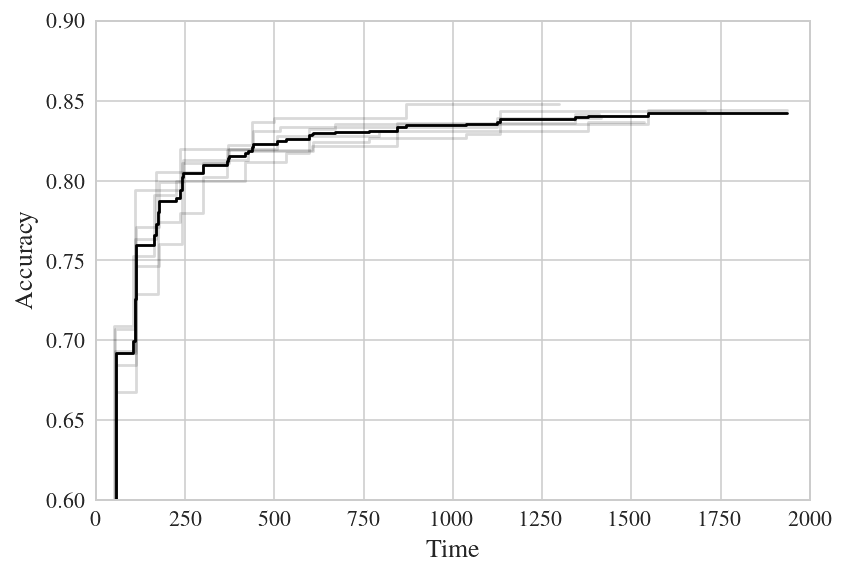

In [259]:
plot_results(all_results_evolution, xlim=(0, 2000), ylim=(0.6, 0.9), ylabel="Accuracy")

In [260]:
file_path_random_static = 'results/RandomSearch2022-04-12-19-15-59'
results_random_static = load_results(file_path_random_static)

In [261]:
np.mean([result.val_metric for result in results_random_static])

0.8271013970238162

In [262]:
sampled_results_random_static = [sample_random_search(results_random_static, 2000) for _ in range(20)]

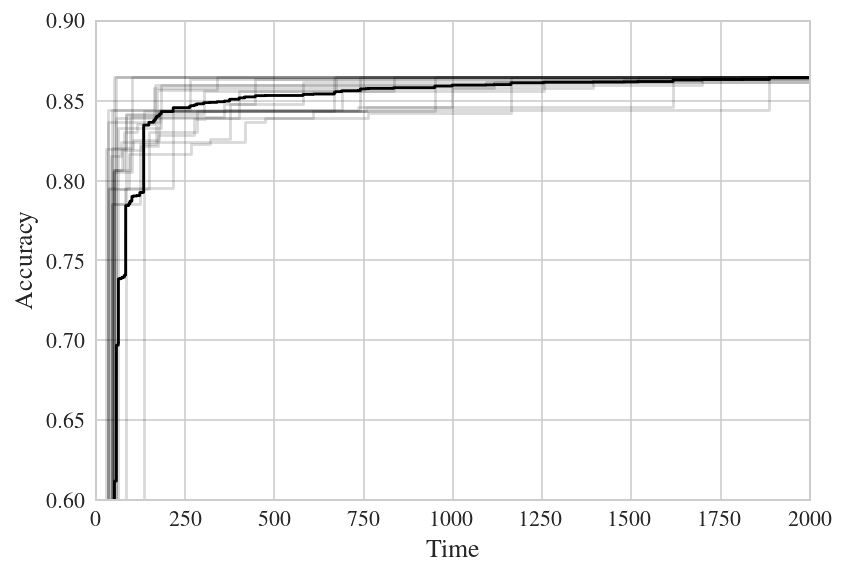

In [264]:
plot_results(sampled_results_random_static, xlim=(0, 2000), ylim=(0.6, 0.9), ylabel="Accuracy")

In [265]:
file_path_random_dynamic = 'results/RandomSearch2022-04-12-20-22-21'
results_random_dynamic = load_results(file_path_random_dynamic)

In [266]:
np.mean([result.val_metric for result in results_random_dynamic])

0.8239888788922383

In [277]:
sampled_results_random_dynamic = [sample_random_search(results_random_dynamic, 2000) for _ in range(20)]

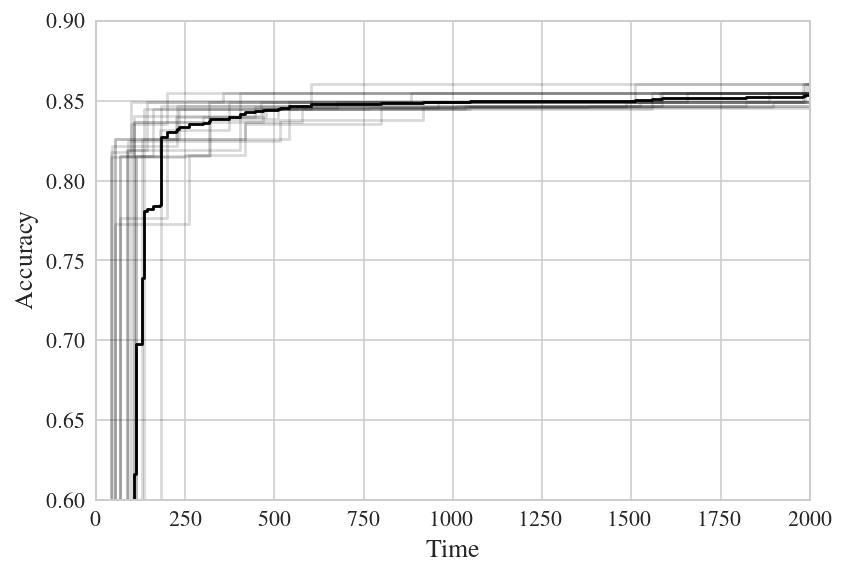

In [278]:
plot_results(sampled_results_random_dynamic, xlim=(0, 2000), ylim=(0.6, 0.9), ylabel="Accuracy")

## SVHN

In [4]:
svhn = get_svhn_dataset()

In [36]:
svhn.X_norm.shape

(99289, 32, 32, 3)

### Evolution

In [37]:
hyperparameters = {
    'regularization_penalty': Hyperparameter(3., 3., 4.5, 0.5),
    'learning_rate': Hyperparameter(0.0004, 0.0001, 0.0006, 0.000025),
    'batch_size': Hyperparameter(32, 16, 64, 4),
}
results = anytime_multirun(Evolution, n_runs=3, save=True, x=svhn.X_norm, y=svhn.y, validation_data=None, fraction=0.025, test_size=0.2,
              layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, hyperparameters=hyperparameters, n_parents=5, population_size=10, 
              n_generations=20, tournament_size=3, n_introduced=2, age_penalty_period=10, use_static_graph=False)


###########################################
Started run 0...
Generation 0: 87.6 s, best val metric 0.2008, [(1, 0.2008, 0.2008, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.1908, 0.1908, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.1888, 0.1888, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.1888, 0.1888, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.1888, 0.1888, 0.001, 0.00042810829830426255, 27, [20, 20, 20, 20, 20]), (1, 0.1888, 0.1888, 0.001, 0.00042810829830426255, 27, [20, 20, 20, 20, 20]), (1, 0.1827, 0.1827, 0.00039756258086969204, 0.0003690929426520164, 31, [20, 20, 20, 20, 20]), (1, 0.1787, 0.1787, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.1767, 0.1767, 0.001, 0.00041934198323308886, 29, [20, 20, 20, 20, 20]), (1, 0.1727, 0.1727, 0.001, 0.00040706460303902844, 26, [20, 20, 20, 20, 20])]
#### Total duration 87.6, overall best val metric 0.20080321285140562 ####
Generation 1: 91.2 s, best val metric 0.2329, [(2, 0.2329, 0.2329, 0.001, 0.0004106671413275443, 29,

In [ ]:
hyperparameters = {
    'regularization_penalty': Hyperparameter(3., 3., 4.5, 0.5),
    'learning_rate': Hyperparameter(0.0004, 0.0001, 0.0006, 0.000025),
    'batch_size': Hyperparameter(32, 16, 64, 4),
}
results = anytime_multirun(Evolution, n_runs=3, save=True, x=svhn.X_norm, y=svhn.y, validation_data=None, fraction=0.025, test_size=0.2,
              layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, hyperparameters=hyperparameters, n_parents=5, population_size=10, 
              n_generations=20, tournament_size=3, n_introduced=2, age_penalty_period=10, use_static_graph=False)


###########################################
Started run 0...
Generation 0: 87.7 s, best val metric 0.2073, [(1, 0.2073, 0.2073, 0.001, 0.00037616031810586836, 32, [20, 20, 20, 20, 20]), (1, 0.2073, 0.2073, 0.001, 0.00037616031810586836, 32, [20, 20, 20, 20, 20]), (1, 0.2012, 0.2012, 0.001, 0.00043549588879164314, 28, [20, 20, 20, 20, 20]), (1, 0.1992, 0.1992, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.1992, 0.1992, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.1992, 0.1992, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.187, 0.187, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.185, 0.185, 0.00045550728571828113, 0.0004219031785438012, 38, [20, 20, 20, 20, 20]), (1, 0.1809, 0.1809, 0.001, 0.00040911140153249923, 27, [20, 20, 20, 20, 20]), (1, 0.1809, 0.1809, 0.001, 0.00040911140153249923, 27, [20, 20, 20, 20, 20])]
#### Total duration 87.7, overall best val metric 0.2073170731707317 ####
Generation 1: 91.1 s, best val metric 0.2154, [(2, 0.2154, 0.2154, 0.001, 0.0003761603181

### Random search

#### Static models

In [6]:
algorithm = RandomSearch()
algorithm.run(
    early_stopping_conv, x=svhn.X_norm, y=svhn.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -3., lambda x: Schedule([StaticEpoch(x, 'l1')])), 
    layer_1_size=UniformRange(10, 100, integer=True),
    layer_2_size=UniformRange(10, 100, integer=True),
    layer_3_size=UniformRange(10, 100, integer=True),
    layer_4_size=UniformRange(10, 100, integer=True),
    layer_5_size=UniformRange(10, 100, integer=True),
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, postprocess_fn=layer_sizes_join_postprocess, max_setbacks=8
)

Run with parameters (5a9ef1e81b(0.0002671189636521127), 0.00033226867636167325, 49, 10, 20, 0.2, False, 8, (94, 91, 73, 73, 75)) started...
Run with parameters (5a9ef1e81b(0.0002671189636521127), 0.00033226867636167325, 49, 10, 20, 0.2, False, 8, (94, 91, 73, 73, 75)) completed, duration 132.0, best_val_loss: 1.1418066024780273, best_val_metric: 0.7349397590361446, best_hidden_layer_sizes: [94, 91, 73, 73, 75]
Total duration 132.0, mean val metric 0.7349397590361446, mean duration 132.0, best overall combination: (5a9ef1e81b(0.0002671189636521127), 0.00033226867636167325, 49, 10, 20, 0.2, False, 8, (94, 91, 73, 73, 75)), val_metric: 0.7349397590361446
Run with parameters (31f6e350ca(5.0661757023497574e-05), 0.000252227438800252, 35, 10, 20, 0.2, False, 8, (29, 21, 75, 66, 97)) started...
Run with parameters (31f6e350ca(5.0661757023497574e-05), 0.000252227438800252, 35, 10, 20, 0.2, False, 8, (29, 21, 75, 66, 97)) completed, duration 97.7, best_val_loss: 1.302300214767456, best_val_metr

In [7]:
len(algorithm.results)

58

In [8]:
dict_results = [result.to_dict() for result in algorithm.results]
save_results(dict_results, name=str(algorithm.__class__.__name__))

Saved results to file results/RandomSearch2022-04-13-13-20-23


#### Dynamic models

In [ ]:
algorithm = RandomSearch()
algorithm.run(
    early_stopping_conv, x=svhn.X_norm, y=svhn.y, validation_data=None, fraction=0.025, test_size=0.2, save=True,
    schedule=PowerRange(-4.5, -3., lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[20, 20, 20, 20, 20],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=8
)

Run with parameters (0f0e3a180c(0.00032987776009358433), [20, 20, 20, 20, 20], 0.00046520109110956146, 36, 10, 20, 0.2, False, 8) started...
Run with parameters (0f0e3a180c(0.00032987776009358433), [20, 20, 20, 20, 20], 0.00046520109110956146, 36, 10, 20, 0.2, False, 8) completed, duration 337.9, best_val_loss: 0.7337753176689148, best_val_metric: 0.7834645669291339, best_hidden_layer_sizes: [23, 17, 61, 56, 449]
Total duration 337.9, mean val metric 0.7834645669291339, mean duration 337.9, best overall combination: (0f0e3a180c(0.00032987776009358433), [20, 20, 20, 20, 20], 0.00046520109110956146, 36, 10, 20, 0.2, False, 8), val_metric: 0.7834645669291339
Saved results to file results/RandomSearch2022-04-13-16-33-04
Run with parameters (4cc6d90d85(0.00018820903114229542), [20, 20, 20, 20, 20], 0.0003561011412828569, 60, 10, 20, 0.2, False, 8) started...
Run with parameters (4cc6d90d85(0.00018820903114229542), [20, 20, 20, 20, 20], 0.0003561011412828569, 60, 10, 20, 0.2, False, 8) compl

In [ ]:
algorithm = RandomSearch()
algorithm.run(
    early_stopping_conv, x=svhn.X_norm, y=svhn.y, validation_data=None, fraction=0.025, test_size=0.2, save=True,
    schedule=PowerRange(-4.5, -3., lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[20, 20, 20, 20, 20],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=8
)

Run with parameters (5f3803d66d(0.0005616253680893003), [20, 20, 20, 20, 20], 0.00011705090666000559, 17, 10, 20, 0.2, False, 8) started...
Run with parameters (5f3803d66d(0.0005616253680893003), [20, 20, 20, 20, 20], 0.00011705090666000559, 17, 10, 20, 0.2, False, 8) completed, duration 488.5, best_val_loss: 0.9197969436645508, best_val_metric: 0.6985743380855397, best_hidden_layer_sizes: [7, 7, 4, 13, 19]
Total duration 488.5, mean val metric 0.6985743380855397, mean duration 488.5, best overall combination: (5f3803d66d(0.0005616253680893003), [20, 20, 20, 20, 20], 0.00011705090666000559, 17, 10, 20, 0.2, False, 8), val_metric: 0.6985743380855397
Saved results to file results/RandomSearch2022-04-13-19-00-30
Run with parameters (31dbcce6ba(0.000109910062541506), [20, 20, 20, 20, 20], 0.0004198245932815237, 58, 10, 20, 0.2, False, 8) started...
Run with parameters (31dbcce6ba(0.000109910062541506), [20, 20, 20, 20, 20], 0.0004198245932815237, 58, 10, 20, 0.2, False, 8) completed, durat

In [ ]:
algorithm = RandomSearch()
algorithm.run(
    early_stopping_conv, x=svhn.X_norm, y=svhn.y, validation_data=None, fraction=0.025, test_size=0.2, save=True,
    schedule=PowerRange(-4.5, -3., lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[20, 20, 20, 20, 20],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=8
)

Run with parameters (47321f8ca7(0.00016314696189118804), [20, 20, 20, 20, 20], 0.0002835684551486907, 56, 10, 20, 0.2, False, 8) started...
Run with parameters (47321f8ca7(0.00016314696189118804), [20, 20, 20, 20, 20], 0.0002835684551486907, 56, 10, 20, 0.2, False, 8) completed, duration 180.4, best_val_loss: 0.9072322249412537, best_val_metric: 0.7698744769874477, best_hidden_layer_sizes: [19, 18, 36, 40, 96]
Total duration 180.4, mean val metric 0.7698744769874477, mean duration 180.4, best overall combination: (47321f8ca7(0.00016314696189118804), [20, 20, 20, 20, 20], 0.0002835684551486907, 56, 10, 20, 0.2, False, 8), val_metric: 0.7698744769874477
Saved results to file results/RandomSearch2022-04-13-20-17-15
Run with parameters (c6db600dec(8.526887609792237e-05), [20, 20, 20, 20, 20], 0.00021488715760193511, 34, 10, 20, 0.2, False, 8) started...
Run with parameters (c6db600dec(8.526887609792237e-05), [20, 20, 20, 20, 20], 0.00021488715760193511, 34, 10, 20, 0.2, False, 8) completed

In [5]:
algorithm = RandomSearch()
algorithm.run(
    early_stopping_conv, x=svhn.X_norm, y=svhn.y, validation_data=None, fraction=0.025, test_size=0.2, save=True,
    schedule=PowerRange(-4.5, -3., lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[20, 20, 20, 20, 20],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=8
)

Run with parameters (a12a5052d4(5.419275220783534e-05), [20, 20, 20, 20, 20], 0.00030765201985797713, 49, 10, 20, 0.2, False, 8) started...
Run with parameters (a12a5052d4(5.419275220783534e-05), [20, 20, 20, 20, 20], 0.00030765201985797713, 49, 10, 20, 0.2, False, 8) completed, duration 290.8, best_val_loss: 1.0334103107452393, best_val_metric: 0.7346938775510204, best_hidden_layer_sizes: [67, 86, 59, 133, 303]
Total duration 290.8, mean val metric 0.7346938775510204, mean duration 290.8, best overall combination: (a12a5052d4(5.419275220783534e-05), [20, 20, 20, 20, 20], 0.00030765201985797713, 49, 10, 20, 0.2, False, 8), val_metric: 0.7346938775510204
Saved results to file results/RandomSearch2022-04-13-21-40-46
Run with parameters (c43539b995(0.0006401307737265588), [20, 20, 20, 20, 20], 0.000210019726929351, 17, 10, 20, 0.2, False, 8) started...
Run with parameters (c43539b995(0.0006401307737265588), [20, 20, 20, 20, 20], 0.000210019726929351, 17, 10, 20, 0.2, False, 8) completed, 

### Grid search

#### Static models

In [18]:
results = anytime_multirun(
    AnytimeGridSearch, n_runs=6, save=True, train_fn=early_stopping_conv, x=svhn.X_norm, y=svhn.y, validation_data=None, 
    fraction=0.025, test_size=0.2, max_duration=3400,
    schedule=PowerRange(-4.5, -3., lambda x: Schedule([StaticEpoch(x, 'l1')])), 
    layer_1_size=UniformRange(10, 100, integer=True),
    layer_2_size=UniformRange(10, 100, integer=True),
    layer_3_size=UniformRange(10, 100, integer=True),
    layer_4_size=UniformRange(10, 100, integer=True),
    layer_5_size=UniformRange(10, 100, integer=True),
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, postprocess_fn=layer_sizes_join_postprocess, max_setbacks=8
)


###########################################
Started run 0...
Run with parameters (72f24adfbd(0.00017782794100389227), 0.00034999999999999994, 40, 10, 20, 0.2, False, 8, (55, 55, 55, 55, 55)) started...
Run with parameters (72f24adfbd(0.00017782794100389227), 0.00034999999999999994, 40, 10, 20, 0.2, False, 8, (55, 55, 55, 55, 55)) completed, duration 88.7, best_val_loss: 1.3889353275299072, best_val_metric: 0.6844181459566075, best_hidden_layer_sizes: [55, 55, 55, 55, 55]
Total duration 88.7, mean val metric 0.6844181459566075, mean duration 88.7, best overall combination: (72f24adfbd(0.00017782794100389227), 0.00034999999999999994, 40, 10, 20, 0.2, False, 8, (55, 55, 55, 55, 55)), val_metric: 0.6844181459566075
Run with parameters (c719d3b53e(7.498942093324559e-05), 0.000225, 52, 10, 20, 0.2, False, 8, (55, 55, 78, 32, 32)) started...
Run with parameters (c719d3b53e(7.498942093324559e-05), 0.000225, 52, 10, 20, 0.2, False, 8, (55, 55, 78, 32, 32)) completed, duration 179.9, best_val_l

#### Dynamic models

In [ ]:
results = anytime_multirun(
    AnytimeGridSearch, n_runs=6, save=True, train_fn=early_stopping_conv, x=svhn.X_norm, y=svhn.y, validation_data=None, 
    fraction=0.025, test_size=0.2, max_duration=3400,
    schedule=PowerRange(-4.5, -3., lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[20, 20, 20, 20, 20],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=8
)


###########################################
Started run 0...
Run with parameters (49e7867b6c(0.00017782794100389227), [20, 20, 20, 20, 20], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8) started...
Run with parameters (49e7867b6c(0.00017782794100389227), [20, 20, 20, 20, 20], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8) completed, duration 151.9, best_val_loss: 0.7907543778419495, best_val_metric: 0.7692307692307693, best_hidden_layer_sizes: [21, 13, 16, 49, 182]
Total duration 151.9, mean val metric 0.7692307692307693, mean duration 151.9, best overall combination: (49e7867b6c(0.00017782794100389227), [20, 20, 20, 20, 20], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8), val_metric: 0.7692307692307693
Run with parameters (c65cc1243b(0.00042169650342858224), [20, 20, 20, 20, 20], 0.000225, 40, 10, 20, 0.2, False, 8) started...
Run with parameters (c65cc1243b(0.00042169650342858224), [20, 20, 20, 20, 20], 0.000225, 40, 10, 20, 0.2, False, 8) completed, duration 298.3, best

##### Limited range of regularization strength

In [5]:
results = anytime_multirun(
    AnytimeGridSearch, n_runs=5, save=True, train_fn=early_stopping_conv, x=svhn.X_norm, y=svhn.y, validation_data=None, 
    fraction=0.025, test_size=0.2, max_duration=3400,
    schedule=PowerRange(-4., -3., lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[20, 20, 20, 20, 20],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=8
)


###########################################
Started run 0...
Run with parameters (0ae51aea5b(0.00031622776601683794), [20, 20, 20, 20, 20], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8) started...
Run with parameters (0ae51aea5b(0.00031622776601683794), [20, 20, 20, 20, 20], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8) completed, duration 193.5, best_val_loss: 0.7247624397277832, best_val_metric: 0.8003913894324853, best_hidden_layer_sizes: [10, 10, 22, 26, 74]
Total duration 193.5, mean val metric 0.8003913894324853, mean duration 193.5, best overall combination: (0ae51aea5b(0.00031622776601683794), [20, 20, 20, 20, 20], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8), val_metric: 0.8003913894324853
Run with parameters (0ae51aea5b(0.00031622776601683794), [20, 20, 20, 20, 20], 0.000225, 40, 10, 20, 0.2, False, 8) started...
Run with parameters (0ae51aea5b(0.00031622776601683794), [20, 20, 20, 20, 20], 0.000225, 40, 10, 20, 0.2, False, 8) completed, duration 328.6, best_

### Analysis

In [331]:
file_paths_evolution = ['results/Evolution2022-04-12-22-55-20']
all_results_evolution = load_results_multi(file_paths_evolution)

In [319]:
best_scores = [results[-1].best_val_metric for results in all_results_evolution]
np.mean(best_scores)

0.7449731033786339

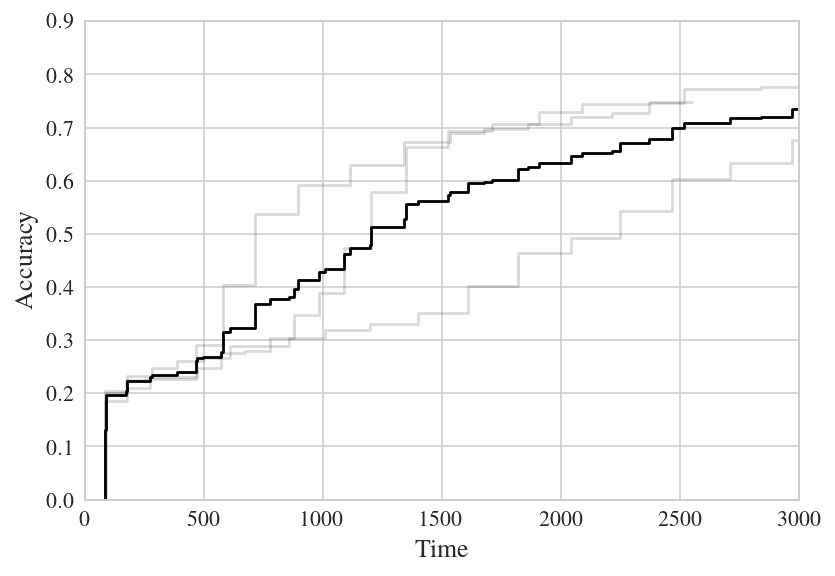

In [323]:
plot_results(all_results_evolution, xlim=(0, 3000), ylim=(0.0, 0.9), ylabel="Accuracy")

In [351]:
file_paths_random_static = ['results/RandomSearch2022-04-13-13-20-23']
results_random_static = load_results(file_paths_random_static)

In [352]:
np.mean([result.val_metric for result in results_random_static])

0.7161212676222658

In [353]:
sampled_results_random_static = [sample_random_search(results_random_static, 3000) for _ in range(20)]

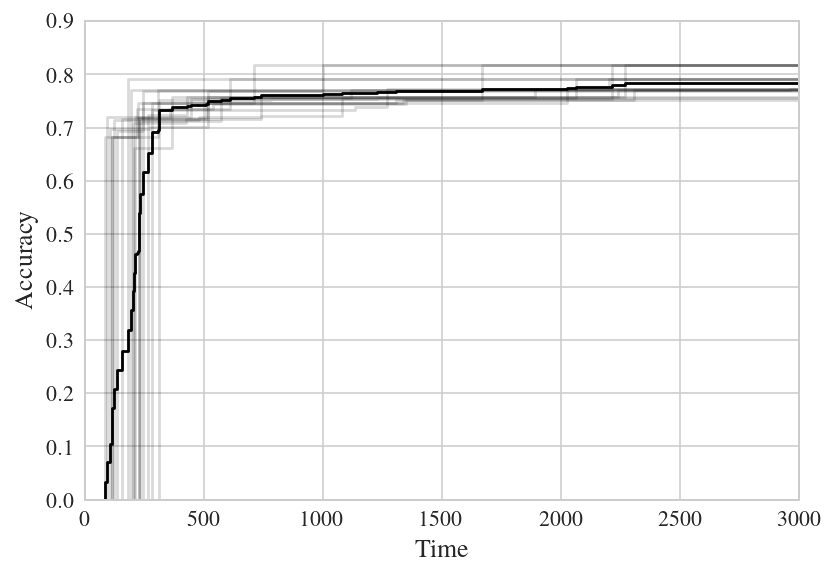

In [355]:
plot_results(sampled_results_random_static, xlim=(0, 3000), ylim=(0.0, 0.9), ylabel="Accuracy")

In [356]:
file_paths_random_dynamic = [
    'results/RandomSearch2022-04-13-16-33-04', 
    'results/RandomSearch2022-04-13-19-00-30', 
    'results/RandomSearch2022-04-13-20-17-15', 
    'results/RandomSearch2022-04-13-21-40-46',
]
results_random_dynamic = load_results(file_paths_random_dynamic)

In [357]:
len(results_random_dynamic)

23

In [358]:
np.mean([result.val_metric for result in results_random_dynamic])

0.7618512226749231

In [365]:
sampled_results_random_dynamic = [sample_random_search(results_random_dynamic, 3000) for _ in range(20)]

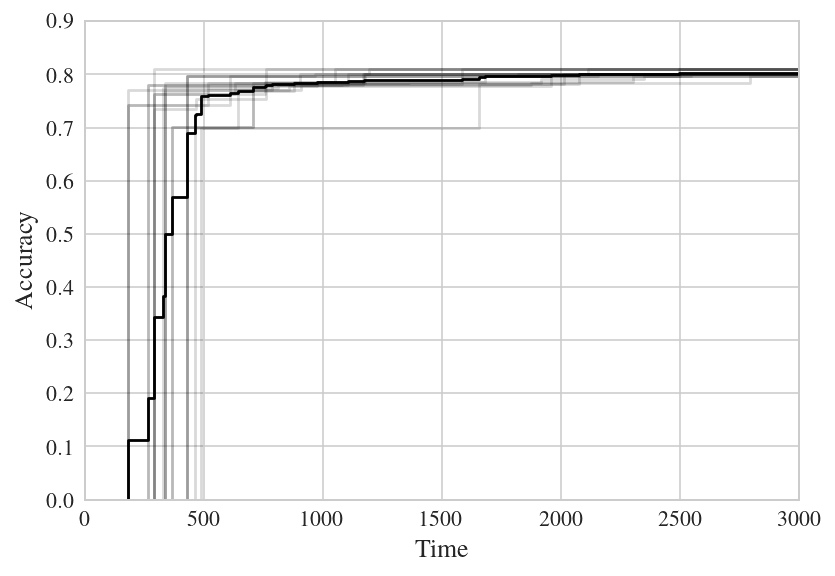

In [366]:
plot_results(sampled_results_random_dynamic, xlim=(0, 3000), ylim=(0.0, 0.9), ylabel="Accuracy")

## SVHN Second variant - limited range of regularization strength

## Cifar 10

In [6]:
cifar10 = get_cifar_10_dataset()

### Evolution

In [11]:
hyperparameters = {
    'regularization_penalty': Hyperparameter(3., 3., 4.5, 0.5),
    'learning_rate': Hyperparameter(0.0004, 0.0001, 0.0006, 0.000025),
    'batch_size': Hyperparameter(32, 16, 64, 4),
}
results = anytime_multirun(Evolution, n_runs=3, save=True, x=cifar10.X_norm, y=cifar10.y, validation_data=None, fraction=0.025, test_size=0.2,
              layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, hyperparameters=hyperparameters, n_parents=5, population_size=10, 
              n_generations=20, tournament_size=3, n_introduced=2, age_penalty_period=10, use_static_graph=False)


###########################################
Started run 0...
Generation 0: 54.0 s, best val metric 0.2752, [(1, 0.2752, 0.2752, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.2685, 0.2685, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.2685, 0.2685, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.2517, 0.2517, 0.001, 0.00041827281855563573, 32, [20, 20, 20, 20, 20]), (1, 0.2517, 0.2517, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.2517, 0.2517, 0.001, 0.00041827281855563573, 32, [20, 20, 20, 20, 20]), (1, 0.2416, 0.2416, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.2416, 0.2416, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.2349, 0.2349, 0.001, 0.00041242855632417694, 26, [20, 20, 20, 20, 20]), (1, 0.2215, 0.2215, 0.001, 0.0003748718603092302, 34, [20, 20, 20, 20, 20])]
#### Total duration 54.0, overall best val metric 0.2751677852348993 ####
Generation 1: 55.2 s, best val metric 0.3188, [(2, 0.3188, 0.3188, 0.0005253298584188764, 0.0004444883800918092, 31, [20, 20, 20, 20, 

In [12]:
hyperparameters = {
    'regularization_penalty': Hyperparameter(3., 3., 4.5, 0.5),
    'learning_rate': Hyperparameter(0.0004, 0.0001, 0.0006, 0.000025),
    'batch_size': Hyperparameter(32, 16, 64, 4),
}
results = anytime_multirun(Evolution, n_runs=3, save=True, x=cifar10.X_norm, y=cifar10.y, validation_data=None, fraction=0.025, test_size=0.2,
              layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, hyperparameters=hyperparameters, n_parents=5, population_size=10, 
              n_generations=20, tournament_size=3, n_introduced=2, age_penalty_period=10, use_static_graph=False)


###########################################
Started run 0...
Generation 0: 55.3 s, best val metric 0.3158, [(1, 0.3158, 0.3158, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.3158, 0.3158, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.3158, 0.3158, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.3059, 0.3059, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.2829, 0.2829, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.2796, 0.2796, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.2697, 0.2697, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.2697, 0.2697, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.2664, 0.2664, 0.001, 0.0004123396645836201, 33, [20, 20, 20, 20, 20]), (1, 0.2566, 0.2566, 0.001, 0.000421104946731487, 34, [20, 20, 20, 20, 20])]
#### Total duration 55.3, overall best val metric 0.3157894736842105 ####
Generation 1: 55.6 s, best val metric 0.3355, [(2, 0.3355, 0.3355, 0.001, 0.00040902655780496557, 31, [20, 20, 20, 20, 20]), (2, 0.3355, 0.3355, 0.001, 0.00040902655780

### Random search

#### Static models

In [10]:
algorithm = RandomSearch()
algorithm.run(
    early_stopping_conv, x=cifar10.X_norm, y=cifar10.y, validation_data=None, fraction=0.025, test_size=0.2, save=True,
    schedule=PowerRange(-4.5, -3., lambda x: Schedule([StaticEpoch(x, 'l1')])), 
    layer_1_size=UniformRange(10, 100, integer=True),
    layer_2_size=UniformRange(10, 100, integer=True),
    layer_3_size=UniformRange(10, 100, integer=True),
    layer_4_size=UniformRange(10, 100, integer=True),
    layer_5_size=UniformRange(10, 100, integer=True),
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, postprocess_fn=layer_sizes_join_postprocess, max_setbacks=8
)

Run with parameters (c49e9a933d(4.588757137574753e-05), 0.00034359136174822916, 22, 10, 20, 0.2, False, 8, (95, 84, 28, 41, 83)) started...
Run with parameters (c49e9a933d(4.588757137574753e-05), 0.00034359136174822916, 22, 10, 20, 0.2, False, 8, (95, 84, 28, 41, 83)) completed, duration 51.9, best_val_loss: 2.0853471755981445, best_val_metric: 0.36486486486486486, best_hidden_layer_sizes: [95, 84, 28, 41, 83]
Total duration 51.9, mean val metric 0.36486486486486486, mean duration 51.9, best overall combination: (c49e9a933d(4.588757137574753e-05), 0.00034359136174822916, 22, 10, 20, 0.2, False, 8, (95, 84, 28, 41, 83)), val_metric: 0.36486486486486486
Saved results to file results/RandomSearch2022-04-14-00-52-07
Run with parameters (9e3874e2dd(7.546386826519235e-05), 0.000447306492235881, 47, 10, 20, 0.2, False, 8, (76, 50, 45, 65, 84)) started...
Run with parameters (9e3874e2dd(7.546386826519235e-05), 0.000447306492235881, 47, 10, 20, 0.2, False, 8, (76, 50, 45, 65, 84)) completed, du

#### Dynamic models

In [9]:
algorithm = RandomSearch()
algorithm.run(
    early_stopping_conv, x=cifar10.X_norm, y=cifar10.y, validation_data=None, fraction=0.025, test_size=0.2, save=True,
    schedule=PowerRange(-4.5, -3., lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[20, 20, 20, 20, 20],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=8
)

Run with parameters (0c3e8edb2b(4.680698276261719e-05), [20, 20, 20, 20, 20], 0.0004585678407981167, 64, 10, 20, 0.2, False, 8) started...
Run with parameters (0c3e8edb2b(4.680698276261719e-05), [20, 20, 20, 20, 20], 0.0004585678407981167, 64, 10, 20, 0.2, False, 8) completed, duration 153.2, best_val_loss: 1.8895153999328613, best_val_metric: 0.4053156146179402, best_hidden_layer_sizes: [85, 135, 59, 137, 58]
Total duration 153.2, mean val metric 0.4053156146179402, mean duration 153.2, best overall combination: (0c3e8edb2b(4.680698276261719e-05), [20, 20, 20, 20, 20], 0.0004585678407981167, 64, 10, 20, 0.2, False, 8), val_metric: 0.4053156146179402
Saved results to file results/RandomSearch2022-04-13-22-27-20
Run with parameters (c5220553a8(8.571569998378494e-05), [20, 20, 20, 20, 20], 0.0003914403977829776, 57, 10, 20, 0.2, False, 8) started...
Run with parameters (c5220553a8(8.571569998378494e-05), [20, 20, 20, 20, 20], 0.0003914403977829776, 57, 10, 20, 0.2, False, 8) completed, d

### Analysis

In [307]:
file_paths_evolution = ['results/Evolution2022-04-14-10-43-18', 'results/Evolution2022-04-14-12-02-07']
all_results_evolution = load_results_multi(file_paths_evolution)

In [308]:
best_scores = [results[-1].best_val_metric for results in all_results_evolution]
np.mean(best_scores)

0.4250472114077341

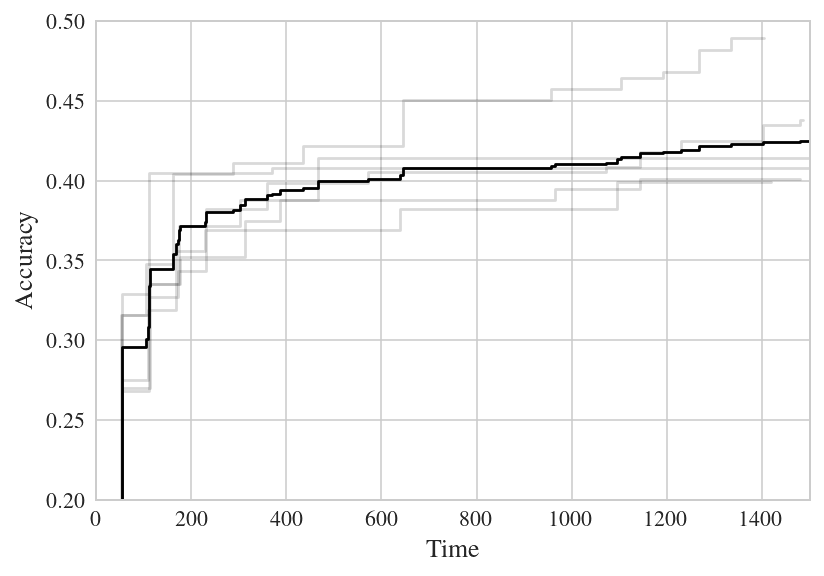

In [309]:
plot_results(all_results_evolution, xlim=(0, 1500), ylim=(0.2, 0.5), ylabel="Accuracy")

In [310]:
file_path_random_static = 'results/RandomSearch2022-04-14-00-52-07'
results_random_static = load_results(file_path_random_static)

In [311]:
np.mean([result.val_metric for result in results_random_static])

0.35838861213277023

In [312]:
sampled_results_random_static = [sample_random_search(results_random_static, 2000) for _ in range(20)]

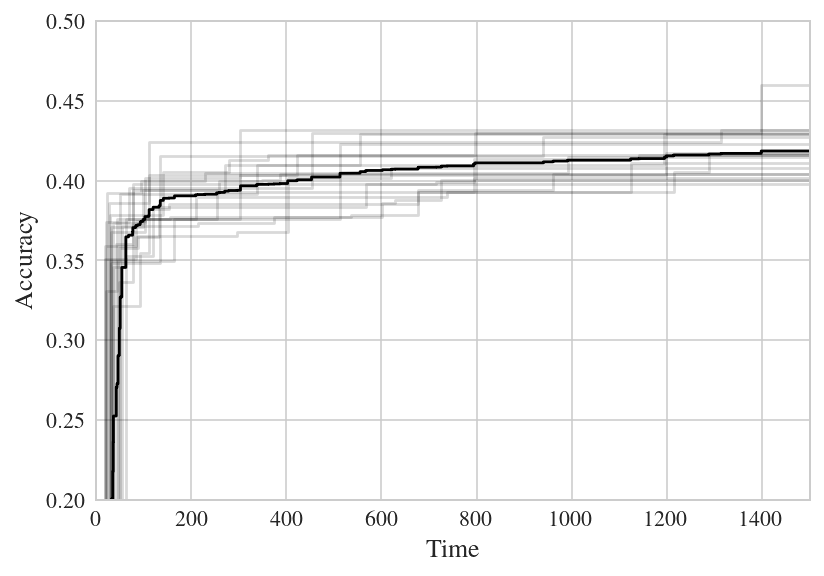

In [313]:
plot_results(sampled_results_random_static, xlim=(0, 1500), ylim=(0.2, 0.5), ylabel="Accuracy")

In [314]:
file_path_random_dynamic = 'results/RandomSearch2022-04-13-22-27-20'
results_random_dynamic = load_results(file_path_random_dynamic)

In [315]:
np.mean([result.val_metric for result in results_random_dynamic])

0.36993052948475785

In [316]:
sampled_results_random_dynamic = [sample_random_search(results_random_dynamic, 2000) for _ in range(20)]

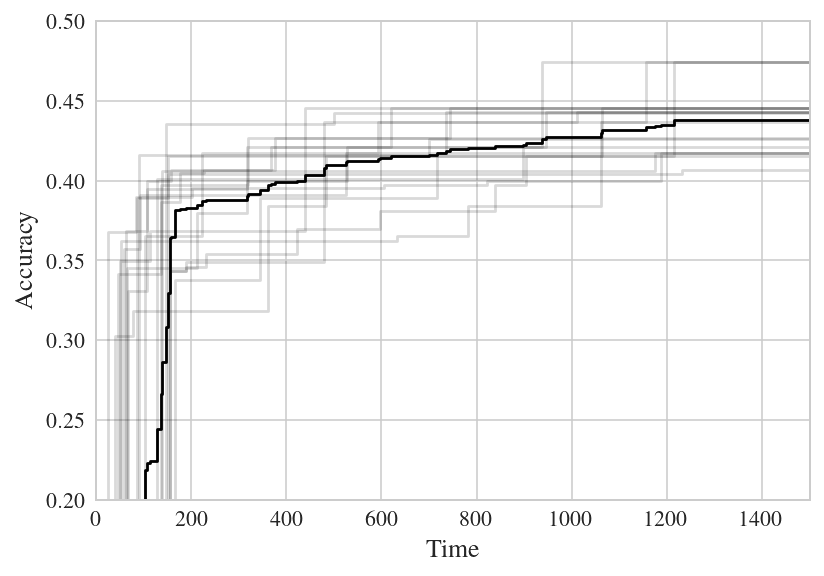

In [317]:
plot_results(sampled_results_random_dynamic, xlim=(0, 1500), ylim=(0.2, 0.5), ylabel="Accuracy")

# Legacy code

## Fashnion MNIST

In [4]:
fashion_mnist = get_fashion_mnist_dataset()

### Random search

#### Static models

In [9]:
random_search = RandomSearch()
random_search.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -2.5, lambda x: Schedule([StaticEpoch(x, 'l1')])), 
    layer_1_size=UniformRange(10, 100, integer=True),
    layer_2_size=UniformRange(10, 100, integer=True),
    layer_3_size=UniformRange(10, 100, integer=True),
    layer_4_size=UniformRange(10, 100, integer=True),
    layer_5_size=UniformRange(10, 100, integer=True),
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, postprocess_fn=layer_sizes_join_postprocess, max_setbacks=2
)

Run with parameters (0e6b7762ad(6.468213629871641e-05), 0.00036839161659472166, 44, 10, 20, 0.2, False, 2, (17, 50, 19, 88, 63)) started...
Run with parameters (0e6b7762ad(6.468213629871641e-05), 0.00036839161659472166, 44, 10, 20, 0.2, False, 2, (17, 50, 19, 88, 63)) completed, best_val_loss: 0.5622777342796326, best_val_metric: 0.8390804597701149, best_hidden_layer_sizes: [17, 50, 19, 88, 63]
Duration 18.6, best overall combination: (0e6b7762ad(6.468213629871641e-05), 0.00036839161659472166, 44, 10, 20, 0.2, False, 2, (17, 50, 19, 88, 63)), val_metric: 0.8390804597701149
Run with parameters (2e122239cb(0.0005530237564695318), 0.0005950746846707398, 64, 10, 20, 0.2, False, 2, (97, 26, 10, 50, 49)) started...
Run with parameters (2e122239cb(0.0005530237564695318), 0.0005950746846707398, 64, 10, 20, 0.2, False, 2, (97, 26, 10, 50, 49)) completed, best_val_loss: 0.5839619040489197, best_val_metric: 0.813953488372093, best_hidden_layer_sizes: [97, 26, 10, 50, 49]
Duration 11.7, best overa

In [13]:
np.mean([result.val_metric for result in random_search.results])

0.8213418297232145

In [24]:
random_search = RandomSearch()
random_search.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -2.5, lambda x: Schedule([StaticEpoch(x, 'l1')])), 
    layer_sizes=UniformRange(10, 100, lambda x: [x] * 5, integer=True),
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=2
)

Run with parameters (05f31057af(0.00011151171128197354), [75, 75, 75, 75, 75], 0.0003179992206569219, 53, 10, 20, 0.2, False, 2) started...
Run with parameters (05f31057af(0.00011151171128197354), [75, 75, 75, 75, 75], 0.0003179992206569219, 53, 10, 20, 0.2, False, 2) completed, best_val_loss: 0.5854276418685913, best_val_metric: 0.8168168168168168, best_hidden_layer_sizes: [75, 75, 75, 75, 75]
Duration 24.9, best overall combination: (05f31057af(0.00011151171128197354), [75, 75, 75, 75, 75], 0.0003179992206569219, 53, 10, 20, 0.2, False, 2), val_metric: 0.8168168168168168
Run with parameters (169fc12288(0.00012404581605019577), [30, 30, 30, 30, 30], 0.00036362942002440883, 35, 10, 20, 0.2, False, 2) started...
Run with parameters (169fc12288(0.00012404581605019577), [30, 30, 30, 30, 30], 0.00036362942002440883, 35, 10, 20, 0.2, False, 2) completed, best_val_loss: 0.5325362682342529, best_val_metric: 0.8052325581395349, best_hidden_layer_sizes: [30, 30, 30, 30, 30]
Duration 24.7, best 

In [25]:
np.mean([result.val_metric for result in random_search.results])

0.8154508574193786

In [31]:
random_search = RandomSearch()
random_search.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -2.5, lambda x: Schedule([StaticEpoch(x, 'l1')])), 
    layer_sizes=UniformRange(10, 100, lambda x: [x] * 5, integer=True),
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=8
)

Run with parameters (dc5a940e0e(0.003101686150188936), [19, 19, 19, 19, 19], 0.00012916165651511398, 34, 10, 20, 0.2, False, 8) started...
Run with parameters (dc5a940e0e(0.003101686150188936), [19, 19, 19, 19, 19], 0.00012916165651511398, 34, 10, 20, 0.2, False, 8) completed, best_val_loss: 0.5111762881278992, best_val_metric: 0.8162162162162162, best_hidden_layer_sizes: [19, 19, 19, 19, 19]
Duration 70.5, best overall combination: (dc5a940e0e(0.003101686150188936), [19, 19, 19, 19, 19], 0.00012916165651511398, 34, 10, 20, 0.2, False, 8), val_metric: 0.8162162162162162
Run with parameters (430ef05d70(0.0006713042122459809), [96, 96, 96, 96, 96], 0.0003194193665359994, 35, 10, 20, 0.2, False, 8) started...
Run with parameters (430ef05d70(0.0006713042122459809), [96, 96, 96, 96, 96], 0.0003194193665359994, 35, 10, 20, 0.2, False, 8) completed, best_val_loss: 0.5851006507873535, best_val_metric: 0.8323863636363636, best_hidden_layer_sizes: [96, 96, 96, 96, 96]
Duration 126.0, best overal

SystemError: <built-in function len> returned a result with an error set

In [32]:
np.mean([result.val_metric for result in random_search.results])

0.8205672813819703

In [33]:
np.mean([result.duration for result in random_search.results])

63.32619188229243

#### Dynamic models

In [18]:
random_search = RandomSearch()
random_search.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[20, 20, 20, 20, 20],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=2
)

Run with parameters (6c51009342(6.64454742238569e-05), [20, 20, 20, 20, 20], 0.0005270695556026855, 51, 10, 20, 0.2, False, 2) started...
Run with parameters (6c51009342(6.64454742238569e-05), [20, 20, 20, 20, 20], 0.0005270695556026855, 51, 10, 20, 0.2, False, 2) completed, best_val_loss: 0.675999641418457, best_val_metric: 0.771117166212534, best_hidden_layer_sizes: [20, 73, 42, 67, 65]
Duration 24.3, best overall combination: (6c51009342(6.64454742238569e-05), [20, 20, 20, 20, 20], 0.0005270695556026855, 51, 10, 20, 0.2, False, 2), val_metric: 0.771117166212534
Run with parameters (757886b014(0.0011168778272064447), [20, 20, 20, 20, 20], 0.00042529012136676006, 34, 10, 20, 0.2, False, 2) started...
Run with parameters (757886b014(0.0011168778272064447), [20, 20, 20, 20, 20], 0.00042529012136676006, 34, 10, 20, 0.2, False, 2) completed, best_val_loss: 0.6109392046928406, best_val_metric: 0.7994350282485876, best_hidden_layer_sizes: [10, 5, 7, 8, 31]
Duration 34.6, best overall combin

In [19]:
np.mean([result.val_metric for result in random_search.results])

0.7985525752869735

In [20]:
np.mean([result.duration for result in random_search.results])

33.04273682832718

In [26]:
random_search = RandomSearch()
random_search.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[20, 20, 20, 20, 20],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=2
)

Run with parameters (470df8c5ec(0.0024571853763312376), [20, 20, 20, 20, 20], 0.00043141821261181686, 26, 10, 20, 0.2, False, 2) started...
Run with parameters (470df8c5ec(0.0024571853763312376), [20, 20, 20, 20, 20], 0.00043141821261181686, 26, 10, 20, 0.2, False, 2) completed, best_val_loss: 0.8513667583465576, best_val_metric: 0.7577464788732394, best_hidden_layer_sizes: [20, 20, 20, 20, 20]
Duration 25.7, best overall combination: (470df8c5ec(0.0024571853763312376), [20, 20, 20, 20, 20], 0.00043141821261181686, 26, 10, 20, 0.2, False, 2), val_metric: 0.7577464788732394
Run with parameters (7d25d495e8(0.00043589252435480573), [20, 20, 20, 20, 20], 0.0005774270813372936, 51, 10, 20, 0.2, False, 2) started...
Run with parameters (7d25d495e8(0.00043589252435480573), [20, 20, 20, 20, 20], 0.0005774270813372936, 51, 10, 20, 0.2, False, 2) completed, best_val_loss: 0.6590991020202637, best_val_metric: 0.775623268698061, best_hidden_layer_sizes: [20, 20, 24, 27, 59]
Duration 27.7, best ove

In [27]:
np.mean([result.val_metric for result in random_search.results])

0.7934547659145048

In [28]:
random_search = RandomSearch()
random_search.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[20, 20, 20, 20, 20],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=8
)

Run with parameters (60158b0e0e(0.00027223295877836694), [20, 20, 20, 20, 20], 0.0004667041191646742, 43, 10, 20, 0.2, False, 8) started...
Run with parameters (60158b0e0e(0.00027223295877836694), [20, 20, 20, 20, 20], 0.0004667041191646742, 43, 10, 20, 0.2, False, 8) completed, best_val_loss: 0.5247147083282471, best_val_metric: 0.833810888252149, best_hidden_layer_sizes: [20, 20, 20, 20, 22]
Duration 48.0, best overall combination: (60158b0e0e(0.00027223295877836694), [20, 20, 20, 20, 20], 0.0004667041191646742, 43, 10, 20, 0.2, False, 8), val_metric: 0.833810888252149
Run with parameters (2a2bb42f9c(0.002127069523543648), [20, 20, 20, 20, 20], 0.0003384749833128299, 60, 10, 20, 0.2, False, 8) started...
Run with parameters (2a2bb42f9c(0.002127069523543648), [20, 20, 20, 20, 20], 0.0003384749833128299, 60, 10, 20, 0.2, False, 8) completed, best_val_loss: 0.5111258029937744, best_val_metric: 0.8342857142857143, best_hidden_layer_sizes: [3, 4, 2, 11, 38]
Duration 132.1, best overall co

In [29]:
np.mean([result.val_metric for result in random_search.results])

0.8234427782159791

In [30]:
np.mean([result.duration for result in random_search.results])

87.67465912212025

In [64]:
random_search = RandomSearch()
random_search.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[20, 20, 20, 20, 20],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=10
)

Run with parameters (63d037a9eb(0.00011360268441832483), [20, 20, 20, 20, 20], 0.00024664030028448457, 30, 10, 20, 0.2, False, 10) started...
Run with parameters (63d037a9eb(0.00011360268441832483), [20, 20, 20, 20, 20], 0.00024664030028448457, 30, 10, 20, 0.2, False, 10) completed, duration 98.7, best_val_loss: 0.5806478261947632, best_val_metric: 0.8245614035087719, best_hidden_layer_sizes: [20, 19, 20, 28, 80]
Total duration 98.7, mean val metric 0.8245614035087719, mean duration 98.7, best overall combination: (63d037a9eb(0.00011360268441832483), [20, 20, 20, 20, 20], 0.00024664030028448457, 30, 10, 20, 0.2, False, 10), val_metric: 0.8245614035087719
Run with parameters (3f556d14be(4.7752285741481555e-05), [20, 20, 20, 20, 20], 0.00037077517843889875, 37, 10, 20, 0.2, False, 10) started...
Run with parameters (3f556d14be(4.7752285741481555e-05), [20, 20, 20, 20, 20], 0.00037077517843889875, 37, 10, 20, 0.2, False, 10) completed, duration 83.3, best_val_loss: 0.6611487865447998, bes

In [63]:
random_search = RandomSearch()
random_search.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[20, 20, 20, 20, 20],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=6
)

Run with parameters (f0541bbe2d(0.0002275631770030383), [20, 20, 20, 20, 20], 0.0005525149068718821, 18, 10, 20, 0.2, False, 6) started...
Run with parameters (f0541bbe2d(0.0002275631770030383), [20, 20, 20, 20, 20], 0.0005525149068718821, 18, 10, 20, 0.2, False, 6) completed, duration 83.4, best_val_loss: 0.5830672979354858, best_val_metric: 0.8050139275766016, best_hidden_layer_sizes: [20, 20, 20, 25, 86]
Total duration 83.4, mean val metric 0.8050139275766016, mean duration 83.4, best overall combination: (f0541bbe2d(0.0002275631770030383), [20, 20, 20, 20, 20], 0.0005525149068718821, 18, 10, 20, 0.2, False, 6), val_metric: 0.8050139275766016
Run with parameters (7ad06e4e19(0.000866824797496868), [20, 20, 20, 20, 20], 0.0003511112648415954, 20, 10, 20, 0.2, False, 6) started...
Run with parameters (7ad06e4e19(0.000866824797496868), [20, 20, 20, 20, 20], 0.0003511112648415954, 20, 10, 20, 0.2, False, 6) completed, duration 120.3, best_val_loss: 0.6533282995223999, best_val_metric: 0.

In [34]:
random_search = RandomSearch()
random_search.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_sizes=[50, 50, 50, 50, 50],
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=8
)

Run with parameters (463e4d3c19(0.00026211059410829736), [50, 50, 50, 50, 50], 0.0003690287789228201, 16, 10, 20, 0.2, False, 8) started...
Run with parameters (463e4d3c19(0.00026211059410829736), [50, 50, 50, 50, 50], 0.0003690287789228201, 16, 10, 20, 0.2, False, 8) completed, best_val_loss: 0.5107776522636414, best_val_metric: 0.8476454293628809, best_hidden_layer_sizes: [20, 8, 11, 16, 98]
Duration 93.6, best overall combination: (463e4d3c19(0.00026211059410829736), [50, 50, 50, 50, 50], 0.0003690287789228201, 16, 10, 20, 0.2, False, 8), val_metric: 0.8476454293628809
Run with parameters (6ee41e6e4f(6.3074541435798e-05), [50, 50, 50, 50, 50], 0.00046130857577600766, 50, 10, 20, 0.2, False, 8) started...
Run with parameters (6ee41e6e4f(6.3074541435798e-05), [50, 50, 50, 50, 50], 0.00046130857577600766, 50, 10, 20, 0.2, False, 8) completed, best_val_loss: 0.522895097732544, best_val_metric: 0.8259587020648967, best_hidden_layer_sizes: [50, 56, 71, 110, 224]
Duration 159.9, best overa

In [35]:
np.mean([result.val_metric for result in random_search.results])

0.8249516220548339

In [36]:
np.mean([result.duration for result in random_search.results])

121.92176241874695

In [21]:
random_search = RandomSearch()
random_search.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -2.5, lambda x: Schedule([DynamicEpoch(x, 'weighted_l1')])), 
    layer_1_size=UniformRange(10, 100, integer=True),
    layer_2_size=UniformRange(10, 100, integer=True),
    layer_3_size=UniformRange(10, 100, integer=True),
    layer_4_size=UniformRange(10, 100, integer=True),
    layer_5_size=UniformRange(10, 100, integer=True),
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, postprocess_fn=layer_sizes_join_postprocess, max_setbacks=2
)

Run with parameters (92da5ff824(0.001327145179613897), 0.0003014684191618844, 31, 10, 20, 0.2, False, 2, (49, 47, 29, 96, 95)) started...
Run with parameters (92da5ff824(0.001327145179613897), 0.0003014684191618844, 31, 10, 20, 0.2, False, 2, (49, 47, 29, 96, 95)) completed, best_val_loss: 0.8706918358802795, best_val_metric: 0.692090395480226, best_hidden_layer_sizes: [49, 47, 29, 96, 95]
Duration 15.6, best overall combination: (92da5ff824(0.001327145179613897), 0.0003014684191618844, 31, 10, 20, 0.2, False, 2, (49, 47, 29, 96, 95)), val_metric: 0.692090395480226
Run with parameters (722de840ea(3.180801097665005e-05), 0.00016195544083580154, 46, 10, 20, 0.2, False, 2, (37, 47, 74, 100, 22)) started...
Run with parameters (722de840ea(3.180801097665005e-05), 0.00016195544083580154, 46, 10, 20, 0.2, False, 2, (37, 47, 74, 100, 22)) completed, best_val_loss: 0.5480306148529053, best_val_metric: 0.8342696629213483, best_hidden_layer_sizes: [37, 47, 74, 100, 24]
Duration 25.5, best overall

In [22]:
np.mean([result.val_metric for result in random_search.results])

0.7815157199219028

### Grid search

In [43]:
grid_search = AnytimeGridSearch()
grid_search.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -2.5, lambda x: Schedule([StaticEpoch(x, 'l1')])), 
    layer_1_size=UniformRange(10, 100, integer=True),
    layer_2_size=UniformRange(10, 100, integer=True),
    layer_3_size=UniformRange(10, 100, integer=True),
    layer_4_size=UniformRange(10, 100, integer=True),
    layer_5_size=UniformRange(10, 100, integer=True),
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, postprocess_fn=layer_sizes_join_postprocess, max_setbacks=2
)

Run with parameters (5aee8427d6(0.00031622776601683794), 0.00034999999999999994, 40, 10, 20, 0.2, False, 2, (55, 55, 55, 55, 55)) started...
Run with parameters (5aee8427d6(0.00031622776601683794), 0.00034999999999999994, 40, 10, 20, 0.2, False, 2, (55, 55, 55, 55, 55)) completed, best_val_loss: 0.6776053309440613, best_val_metric: 0.8048128342245989, best_hidden_layer_sizes: [55, 55, 55, 55, 55]
Duration 23.7, best overall combination: (5aee8427d6(0.00031622776601683794), 0.00034999999999999994, 40, 10, 20, 0.2, False, 2, (55, 55, 55, 55, 55)), val_metric: 0.8048128342245989
Run with parameters (928f3d7753(0.001), 0.00034999999999999994, 40, 10, 20, 0.2, False, 2, (78, 55, 32, 78, 55)) started...
Run with parameters (928f3d7753(0.001), 0.00034999999999999994, 40, 10, 20, 0.2, False, 2, (78, 55, 32, 78, 55)) completed, best_val_loss: 0.5780321359634399, best_val_metric: 0.8153409090909091, best_hidden_layer_sizes: [78, 55, 32, 78, 55]
Duration 17.6, best overall combination: (928f3d775

In [44]:
np.mean([result.val_metric for result in grid_search.results])

0.8205077545748471

In [45]:
grid_search = AnytimeGridSearch()
grid_search.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
    schedule=PowerRange(-4.5, -2.5, lambda x: Schedule([StaticEpoch(x, 'l1')])), 
    layer_sizes=UniformRange(10, 100, lambda x: [x] * 5, integer=True),
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=8
)

Run with parameters (5aee8427d6(0.00031622776601683794), [55, 55, 55, 55, 55], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8) started...
Run with parameters (5aee8427d6(0.00031622776601683794), [55, 55, 55, 55, 55], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8) completed, best_val_loss: 0.5153456330299377, best_val_metric: 0.835195530726257, best_hidden_layer_sizes: [55, 55, 55, 55, 55]
Duration 38.0, best overall combination: (5aee8427d6(0.00031622776601683794), [55, 55, 55, 55, 55], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8), val_metric: 0.835195530726257
Run with parameters (928f3d7753(0.001), [55, 55, 55, 55, 55], 0.00034999999999999994, 28, 10, 20, 0.2, False, 8) started...
Run with parameters (928f3d7753(0.001), [55, 55, 55, 55, 55], 0.00034999999999999994, 28, 10, 20, 0.2, False, 8) completed, best_val_loss: 0.47439122200012207, best_val_metric: 0.8342696629213483, best_hidden_layer_sizes: [55, 55, 55, 55, 55]
Duration 48.9, best overall combination: (5aee8427d6

In [46]:
np.mean([result.val_metric for result in grid_search.results])

0.82538304344781

In [49]:
grid_search = AnytimeGridSearch()
grid_search.run(
    early_stopping_conv, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2, randomize=False,
    schedule=PowerRange(-4.5, -2.5, lambda x: Schedule([StaticEpoch(x, 'l1')])), 
    layer_sizes=UniformRange(10, 100, lambda x: [x] * 5, integer=True),
    learning_rate=UniformRange(0.0001, 0.0006),
    batch_size=UniformRange(16, 64, integer=True),
    output_neurons=10, min_new_neurons=20, growth_percentage=0.2, use_static_graph=False, max_setbacks=8
)

Run with parameters (5aee8427d6(0.00031622776601683794), [55, 55, 55, 55, 55], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8) started...
Run with parameters (5aee8427d6(0.00031622776601683794), [55, 55, 55, 55, 55], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8) completed, best_val_loss: 0.5916856527328491, best_val_metric: 0.8181818181818182, best_hidden_layer_sizes: [55, 55, 55, 55, 55]
Duration 40.6, best overall combination: (5aee8427d6(0.00031622776601683794), [55, 55, 55, 55, 55], 0.00034999999999999994, 40, 10, 20, 0.2, False, 8), val_metric: 0.8181818181818182
Run with parameters (5aee8427d6(0.00031622776601683794), [78, 78, 78, 78, 78], 0.00034999999999999994, 28, 10, 20, 0.2, False, 8) started...
Run with parameters (5aee8427d6(0.00031622776601683794), [78, 78, 78, 78, 78], 0.00034999999999999994, 28, 10, 20, 0.2, False, 8) completed, best_val_loss: 0.6058548092842102, best_val_metric: 0.8410404624277457, best_hidden_layer_sizes: [78, 78, 78, 78, 78]
Duration 62.0, be

In [50]:
np.mean([result.val_metric for result in grid_search.results])

0.8320429139525738

### Evolution

In [45]:
hyperparameters = {
    'regularization_penalty': Hyperparameter(3., 3., 4.5, 0.5),
    'learning_rate': Hyperparameter(0.0004, 0.0001, 0.0006, 0.000025),
    'batch_size': Hyperparameter(32, 16, 64, 4),
}
results = anytime_multirun(Evolution, n_runs=1, save=True, x=fashion_mnist.X_norm, y=fashion_mnist.y, validation_data=None, fraction=0.025, test_size=0.2,
              layer_sizes=[20, 20, 20, 20, 20], output_neurons=10, hyperparameters=hyperparameters, n_parents=5, population_size=10, 
              n_generations=1, tournament_size=3, n_introduced=2, age_penalty_period=10, use_static_graph=False)


###########################################
Started run 0...
Generation 0: 51.7 s, best val metric 0.7243, [(1, 0.7243, 0.7243, 0.001, 0.00045047822868158314, 26, [20, 20, 20, 20, 20]), (1, 0.6804, 0.6804, 0.00036921351158514465, 0.00042328904879388937, 33, [20, 20, 20, 20, 20]), (1, 0.6804, 0.6804, 0.00036921351158514465, 0.00042328904879388937, 33, [20, 20, 20, 20, 20]), (1, 0.6774, 0.6774, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6716, 0.6716, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6716, 0.6716, 0.0002318534912545094, 0.0004299492304831737, 23, [20, 20, 20, 31, 20]), (1, 0.6686, 0.6686, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6686, 0.6686, 0.001, 0.0004, 32, [20, 20, 20, 20, 20]), (1, 0.6569, 0.6569, 0.001, 0.00039688787629910707, 35, [20, 20, 20, 20, 20]), (1, 0.651, 0.651, 0.0006242303735264302, 0.0004086689425332929, 30, [20, 20, 20, 20, 20])]
#### Total duration 51.7, overall best val metric 0.7243401759530792 ####
Total run duration 51.67835474014282, m

## Cifar 10

In [51]:
cifar10 = get_cifar_10_dataset()

### Random search

#### Static models